In [101]:
import os
import numpy as np
import glob
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter, find_peaks
import pickle as pkl
from plot_utils import extract_results
from itertools import compress
import seaborn as sns
figures_path = os.path.join(os.getcwd(), 'Figures')
from plot_utils import get_templates

In [102]:

file_name = '1slice_DS_Baseline_n_rem'

list_of_noise_files = glob.glob(os.path.join(os.getcwd(), 'saved_models', file_name, f'figure_data_noise=*'))
list_of_noise_levels_all = [float(file.split('noise=')[1].split('.pkl')[0]) for file in list_of_noise_files]
list_of_noise_levels_valid = list(filter(lambda x: x > 0, list_of_noise_levels_all))
list_of_noise_levels_valid = list(filter(lambda x: x not in noise_levels_to_remove, list_of_noise_levels_valid))
valid_idx = np.array([list_of_noise_levels_all[i] in list_of_noise_levels_valid for i in range(len(list_of_noise_levels_all))])
list_of_noise_files_valid = list(compress(list_of_noise_files, valid_idx))
list_of_noise_files_valid = [list_of_noise_files_valid[i] for i in np.argsort(list_of_noise_levels_valid)]
list_of_noise_levels_valid = np.sort(list_of_noise_levels_valid)
pal = sns.cubehelix_palette(len(list_of_noise_levels_valid), reverse=True)

In [157]:
def plot_templates(file_name, cam_target, text_height, before=5., after=5., template_opt='spindle', task='all',
                   num_patients=None, random=False, plot_noisy=False, noise_levels_to_remove=[]):
    # If running from notebook, it is advisable to leave num_patients None, and so the highest number of patients will be loaded
    assert (template_opt in ['rem', 'emg', 'sw', 'spindle'])
    random_str = 'random_' if random else ''
    if num_patients is None:
        # Load saved templates (find the highest number of patients)
        list_of_templates = glob.glob(f'plot_results/{random_str}{template_opt}_template_class{cam_target}_{file_name}*')
        list_of_num_patients = [int(file.split('patients')[0].split('_')[-1]) for file in list_of_templates]
        best_file_idx = np.argmax(list_of_num_patients)
        num_patients = list_of_num_patients[best_file_idx]
        new_file_name = f'{random_str}{template_opt}_template_class{cam_target}_{file_name}_' \
                     f'{num_patients}patients_'

        template_file_name = list_of_templates[best_file_idx]
    else:
        new_file_name = f'{random_str}{template_opt}_template_class{cam_target}_{file_name}_' \
                             f'{num_patients}patients_'
        template_file_name = f'plot_results/{new_file_name}'
    print(f"Loaded file name: {template_file_name}")
    with open(template_file_name, 'rb') as f:
        templates = pkl.load(f)
    num_templates = templates.shape[1]
    # Normalize templates
    for i in range(num_templates):
        cam_i = templates[:, i]
        if ((cam_i - cam_i.mean()) != 0).sum() < 5:
            continue
        if max(cam_i) != min(cam_i):
            cam_i = (cam_i - min(cam_i)) / (max(cam_i) - min(cam_i))
            templates[:, i] = cam_i

    # X-axis in ms units
    templates_ts = np.linspace(-before * 1000, after * 1000, templates.shape[0], endpoint=False)

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    mean_cam = np.mean(templates, axis=1)
#     mean_cam = savgol_filter(mean_cam, 11, 2)

    ax.plot(templates_ts, mean_cam, '-k', label='Activation')
#     ax.tick_params(direction='out', length=17, width=2, colors='black',
#                grid_color='grey', grid_alpha=0.5)
    plt.locator_params(nbins=4)
    
    
    if plot_noisy:
        # get lists of noisy templates: valid (noise > 0) and sorted (for the coloring to be meaningful)
        str_s = os.path.join(os.getcwd(), 'plot_results','noise',f'random_{new_file_name}figure_data_noise=*')
#         str_s = os.path.join(os.getcwd(), 'plot_results','noise','random_sw_template_class0_1slice_DS_Baseline_n_rem_100patients_figure_data_noise=0')
        print(str_s)
        list_of_noise_files = glob.glob(str_s)
        print(f'list_of_noise_files:')
        print(list_of_noise_files)
        list_of_noise_levels_all = [float(file.split('noise=')[1].split('.pkl')[0]) for file in list_of_noise_files]
        list_of_noise_levels_valid = list(filter(lambda x: x > 0 and x<0.9, list_of_noise_levels_all))
        list_of_noise_levels_valid = list(filter(lambda x: x not in noise_levels_to_remove, list_of_noise_levels_valid))
        valid_idx = np.array([list_of_noise_levels_all[i] in list_of_noise_levels_valid for i in range(len(list_of_noise_levels_all))])
        list_of_noise_files_valid = list(compress(list_of_noise_files, valid_idx))
        list_of_noise_files_valid = [list_of_noise_files_valid[i] for i in np.argsort(list_of_noise_levels_valid)]
        list_of_noise_levels_valid = np.sort(list_of_noise_levels_valid)
        pal = sns.cubehelix_palette(len(list_of_noise_levels_valid), reverse=True)

        for i_noise, noise in enumerate(list_of_noise_levels_valid):
            with open(list_of_noise_files_valid[i_noise], 'rb') as h:
                save_data_noise = pkl.load(h)
            
            for i in range(save_data_noise.shape[1]):
                cam_i = save_data_noise[:, i]
                if ((cam_i - cam_i.mean()) != 0).sum() < 5:
                    continue
                if max(cam_i) != min(cam_i):
                    cam_i = (cam_i - min(cam_i)) / (max(cam_i) - min(cam_i))
                    save_data_noise[:, i] = cam_i
                    
            mean_cam_noise = np.mean(save_data_noise, axis=1) # np.mean(save_data_noise['cam_mat'], axis=1)
            sns.lineplot(x=templates_ts, y=mean_cam_noise, label=noise, color=pal[i_noise])

    
    plt.xticks(fontsize=21)
    plt.yticks(fontsize=21)
    ax.set_xlabel('Time [ms]', fontdict={'size': 25})
    ax.set_ylabel('Amplitude [ms]', fontdict={'size': 25})
    plt.axvline(0, color='red', linestyle='--')

    if task == 'all':
        target_class = {0: 'Wake', 1: 'N1', 2: 'N2', 3: 'N3', 4: 'REM'}
    elif task == 'wake_rem':
        target_class = {0: 'Wake', 1: 'REM'}
    elif task == 'rem_nrem':
        target_class = {0: 'NREM', 1: 'REM'}

    template_name_hloc = {'spindle': -2800, 'sw': -2200, 'emg': -500, 'rem': -3300}
    template_name_print = {'spindle': 'Spindle Start', 'sw': 'SW Start', 'emg': 'Movement Onset',
                           'rem': 'Eye movement '}

    ax.text(template_name_hloc[template_opt], text_height, template_name_print[template_opt],
            fontdict={'size': 21, 'style': 'italic', 'color': 'red'})
    plt.grid()
    plt.legend(loc=1, prop={'size': 21})
    plt.show()
    print(f'Averaged over {num_patients} patients and {num_templates} detections')
    return fig

In [26]:
with open(os.path.join(os.getcwd(), 'plot_results', 'noise','random_sw_template_class0_1slice_DS_Baseline_n_rem_6000patients_figure_data_noise=1'), 'rb') as h:
    save_data_noise = pkl.load(h)
    

        


## Figure 4 (a): Slow waves baseline

Classification Performance:
Accuracy: 90.95, Kappa: 0.71, f1m: 0.91, f1M: 0.86

Independence results
R2: 0.723

Loaded file name: plot_results/sw_template_class0_1slice_DS_Baseline_n_rem_6000patients_


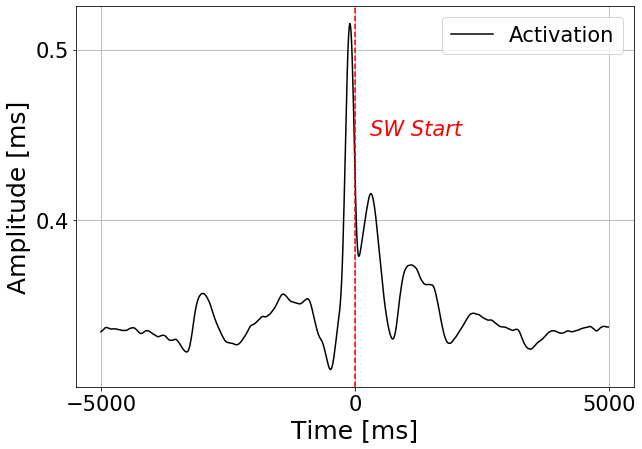

Averaged over 6000 patients and 37327 detections


In [121]:
file_name = '1slice_DS_Baseline_n_rem'
cam_target = 0
template_opt = 'sw'
task = 'rem_nrem'
extract_results(file_name)
fig = plot_templates(file_name=file_name, cam_target=cam_target, text_height=0.45, template_opt=template_opt, before=5, after=5, task=task, random=False,plot_noisy=False)
fig.savefig(f'Figures/{template_opt}_{file_name}.png', dpi=500)
# fig = plot_templates(file_name=file_name, cam_target=cam_target, text_height=0.58, template_opt=template_opt, before=5, after=5, task=task, random=True)
# fig.savefig(f'Figures/{template_opt}_{file_name}_random.png', dpi=500)

## Figure 4 (b): Slow waves (HSIC)

Classification Performance:
Accuracy: 90.21, Kappa: 0.68, f1m: 0.90, f1M: 0.84

Independence results
R2: -0.037

Rep2Label Performance:
Accuracy: 90.54, Kappa: 0.70, f1m: 0.91, f1M: 0.85

Loaded file name: plot_results/sw_template_class0_1slice_DS_frequency_lambda20*0.25_lsb_remNrem_20_73_6001patients


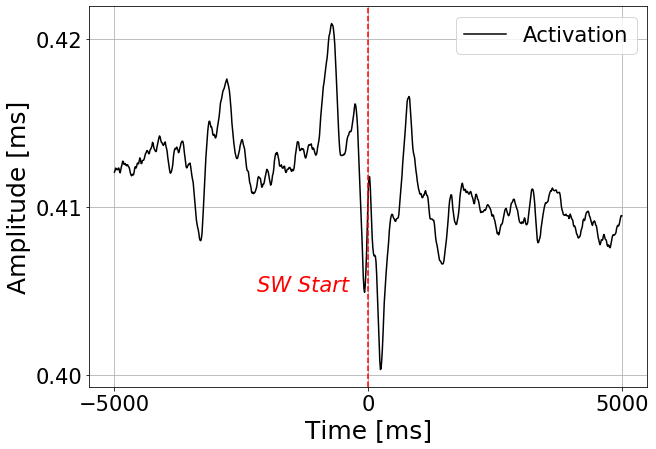

Averaged over 6001 patients and 63077 detections


In [134]:
file_name = '1slice_DS_frequency_lambda20*0.25_lsb_remNrem_20_73'
cam_target = 0
template_opt = 'sw'
task = 'rem_nrem'
extract_results(file_name)
fig = plot_templates(file_name=file_name, cam_target=cam_target, text_height=0.405, template_opt=template_opt, before=5, after=5, task=task, random=False, plot_noisy=False)
fig.savefig(f'Figures/{template_opt}_{file_name}.png', dpi=500)
# fig = plot_templates(file_name=file_name, cam_target=cam_target, text_height=0.58, template_opt=template_opt, before=5, after=5, task=task, random=True)
# fig.savefig(f'Figures/{template_opt}_{file_name}_random.png', dpi=500)

## Figure 5 (a): Spindles baseline

Classification Performance:
Accuracy: 90.95, Kappa: 0.71, f1m: 0.91, f1M: 0.86

Independence results
R2: 0.723

Loaded file name: plot_results/spindle_template_class0_1slice_DS_Baseline_n_rem_6000patients_


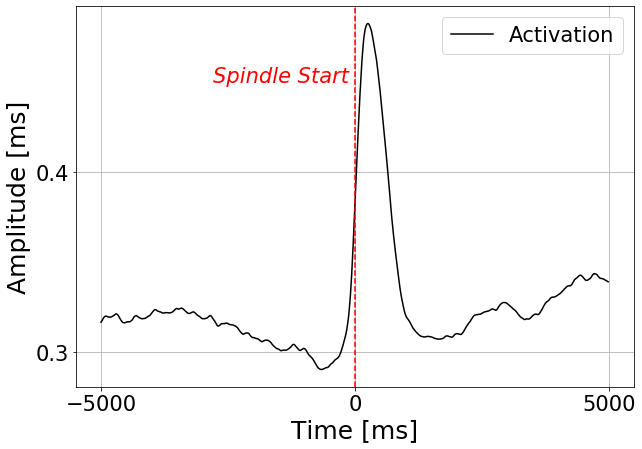

Averaged over 6000 patients and 10454 detections


In [140]:
file_name = '1slice_DS_Baseline_n_rem'
cam_target = 0
template_opt = 'spindle'
task = 'rem_nrem'
extract_results(file_name)
fig = plot_templates(file_name=file_name, cam_target=cam_target, text_height=0.45, template_opt=template_opt, before=5, after=5, task=task, random=False,plot_noisy=False)
fig.savefig(f'Figures/{template_opt}_{file_name}.png', dpi=500)
# fig = plot_templates(file_name=file_name, cam_target=cam_target, text_height=0.490, template_opt=template_opt, before=5, after=5, task=task, random=True)
# fig.savefig(f'Figures/{template_opt}_{file_name}_random.png', dpi=500)

## Figure 5 (b): Spindles HSIC

Classification Performance:
Accuracy: 90.21, Kappa: 0.68, f1m: 0.90, f1M: 0.84

Independence results
R2: -0.037

Rep2Label Performance:
Accuracy: 90.54, Kappa: 0.70, f1m: 0.91, f1M: 0.85

Loaded file name: plot_results/spindle_template_class0_1slice_DS_frequency_lambda20*0.25_lsb_remNrem_20_73_6001patients
/data/deep-sleep-mind/plot_results/noise/random_spindle_template_class0_1slice_DS_frequency_lambda20*0.25_lsb_remNrem_20_73_6001patients_figure_data_noise=*
list_of_noise_files:
['/data/deep-sleep-mind/plot_results/noise/random_spindle_template_class0_1slice_DS_frequency_lambda20*0.25_lsb_remNrem_20_73_6001patients_figure_data_noise=1', '/data/deep-sleep-mind/plot_results/noise/random_spindle_template_class0_1slice_DS_frequency_lambda20*0.25_lsb_remNrem_20_73_6001patients_figure_data_noise=0.05', '/data/deep-sleep-mind/plot_results/noise/random_spindle_template_class0_1slice_DS_frequency_lambda20*0.25_lsb_remNrem_20_73_6001patients_figure_data_noise=0.8', '/data/deep-sleep-mind/plot_

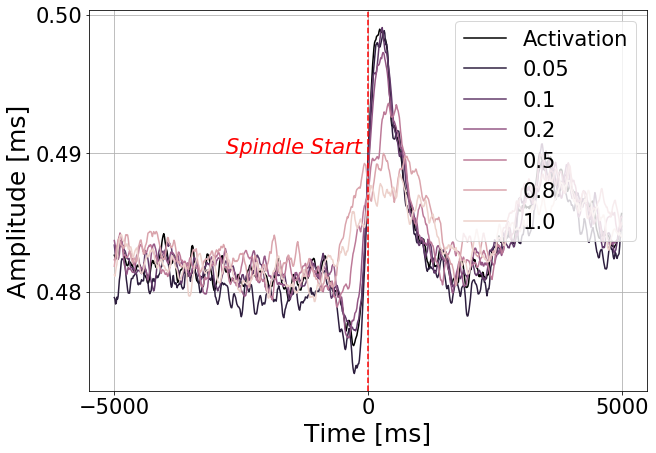

Averaged over 6001 patients and 19219 detections


In [145]:
file_name = '1slice_DS_frequency_lambda20*0.25_lsb_remNrem_20_73'
cam_target = 0
template_opt = 'spindle'
task = 'rem_nrem'
extract_results(file_name)
# print(f'plot_results/{template_opt}_template_class{cam_target}_{file_name}*')
fig = plot_templates(file_name=file_name, cam_target=cam_target, text_height=0.49, template_opt=template_opt, before=5, after=5, task=task, random=False,plot_noisy=True)
fig.savefig(f'Figures/{template_opt}_{file_name}_noise.png', dpi=500)
# fig = plot_templates(file_name=file_name, cam_target=cam_target, text_height=0.490, template_opt=template_opt, before=5, after=5, task=task, random=True)
# fig.savefig(f'Figures/{template_opt}_{file_name}_random.png', dpi=500)

## Figure 6 (a): EOG baseline

Classification Performance:
Accuracy: 90.95, Kappa: 0.71, f1m: 0.91, f1M: 0.86

Independence results
R2: 0.723

Loaded file name: plot_results/rem_template_class1_1slice_DS_Baseline_n_rem_6000patients
/data/deep-sleep-mind/plot_results/noise/random_rem_template_class1_1slice_DS_Baseline_n_rem_6000patients_figure_data_noise=*
list_of_noise_files:
['/data/deep-sleep-mind/plot_results/noise/random_rem_template_class1_1slice_DS_Baseline_n_rem_6000patients_figure_data_noise=1', '/data/deep-sleep-mind/plot_results/noise/random_rem_template_class1_1slice_DS_Baseline_n_rem_6000patients_figure_data_noise=0.8', '/data/deep-sleep-mind/plot_results/noise/random_rem_template_class1_1slice_DS_Baseline_n_rem_6000patients_figure_data_noise=0.1', '/data/deep-sleep-mind/plot_results/noise/random_rem_template_class1_1slice_DS_Baseline_n_rem_6000patients_figure_data_noise=0.5']


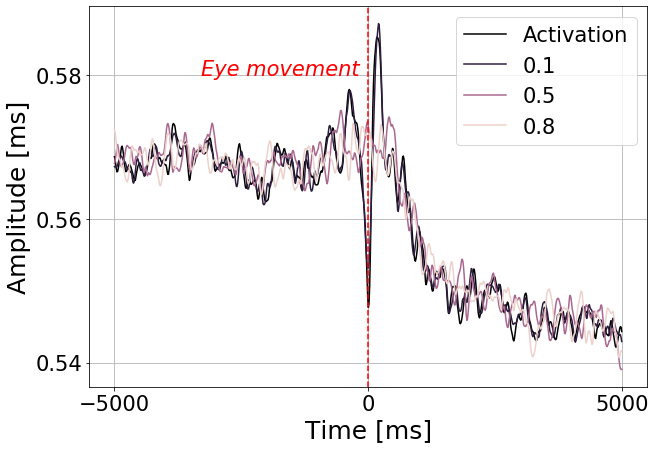

Averaged over 6000 patients and 5556 detections


In [158]:
file_name = '1slice_DS_Baseline_n_rem'
cam_target = 1
template_opt = 'rem'
task = 'rem_nrem'
extract_results(file_name)
# print(f'plot_results/{template_opt}_template_class{cam_target}_{file_name}*')
fig = plot_templates(file_name=file_name, cam_target=cam_target, text_height=0.58, template_opt=template_opt, before=5, after=5, task=task, random=False, plot_noisy=True)

fig.savefig(f'Figures/{template_opt}_{file_name}_noise.png', dpi=500)
# fig = plot_templates(file_name=file_name, cam_target=cam_target, text_height=0.490, template_opt=template_opt, before=5, after=5, task=task, random=True)
# fig.savefig(f'Figures/{template_opt}_{file_name}_random.png', dpi=500)

## Figure 6 (b): EOG HSIC

Classification Performance:
Accuracy: 90.21, Kappa: 0.68, f1m: 0.90, f1M: 0.84

Independence results
R2: -0.037

Rep2Label Performance:
Accuracy: 90.54, Kappa: 0.70, f1m: 0.91, f1M: 0.85

Loaded file name: plot_results/rem_template_class1_1slice_DS_frequency_lambda20*0.25_lsb_remNrem_20_73_6001patients
/data/deep-sleep-mind/plot_results/noise/random_rem_template_class1_1slice_DS_frequency_lambda20*0.25_lsb_remNrem_20_73_6001patients_figure_data_noise=*
list_of_noise_files:
['/data/deep-sleep-mind/plot_results/noise/random_rem_template_class1_1slice_DS_frequency_lambda20*0.25_lsb_remNrem_20_73_6001patients_figure_data_noise=0.2', '/data/deep-sleep-mind/plot_results/noise/random_rem_template_class1_1slice_DS_frequency_lambda20*0.25_lsb_remNrem_20_73_6001patients_figure_data_noise=1', '/data/deep-sleep-mind/plot_results/noise/random_rem_template_class1_1slice_DS_frequency_lambda20*0.25_lsb_remNrem_20_73_6001patients_figure_data_noise=0.5', '/data/deep-sleep-mind/plot_results/noise/random_

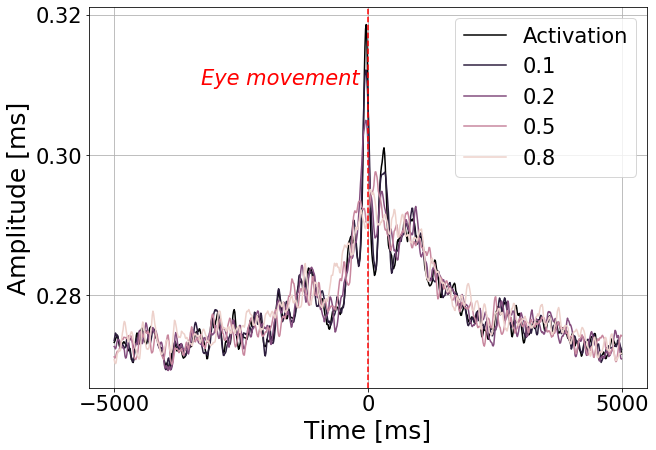

Averaged over 6001 patients and 5556 detections


In [159]:
file_name = '1slice_DS_frequency_lambda20*0.25_lsb_remNrem_20_73'
cam_target = 1
template_opt = 'rem'
task = 'rem_nrem'
extract_results(file_name)
fig = plot_templates(file_name=file_name, cam_target=cam_target, text_height=0.31, template_opt=template_opt, before=5, after=5, task=task, random=False,plot_noisy=True)
fig.savefig(f'Figures/{template_opt}_{file_name}_noise.png', dpi=500)
# fig = plot_templates(file_name=file_name, cam_target=cam_target, text_height=0.29, template_opt=template_opt, before=5, after=5, task=task, random=True)
# fig.savefig(f'Figures/{template_opt}_{file_name}_random.png', dpi=500)

In [32]:
file_name = "1slice_DS_frequency_lambda20*0.25_lsb_remNrem_20_73"
extract_results(file_name)
normalize_signals = True
cuda_id = 2
random = True
oversample = False
gap_norm_opt = 'batch_norm'
task = 'rem_nrem'  # ['rem_nrem', 'wake_rem', 'all']
num_patients = 600  # There are 1570 patients in the test set
cam_target = 1

template_opt = 'rem'  # in ['spindle', 'activation', 'sw', 'rem', 'emg']
num_ch = 2
before, after = 5, 5  # sec
#0.05, # 0.1 # 0.2, 0.5 # 1
noise_inter = 0.8
templates = get_templates(file_name=file_name, template_opt=template_opt, cam_target=cam_target,
                          num_patients=num_patients, num_ch=num_ch, before=before, after=after, task=task,
                          try2load=False, cuda_id=cuda_id, random=random, gap_norm_opt=gap_norm_opt,
                          normalize_signals=normalize_signals, oversample=oversample, noise_inter=noise_inter)
# plot_templates(file_name=file_name, cam_target=cam_target, text_height=0.3005, template_opt=template_opt,
#                before=5, after=5, task=task, random=random)

Classification Performance:
Accuracy: 90.21, Kappa: 0.68, f1m: 0.90, f1M: 0.84

Independence results
R2: -0.037

Rep2Label Performance:
Accuracy: 90.54, Kappa: 0.70, f1m: 0.91, f1M: 0.85

dataset_dir = ALL0.05
Sample Frequency: 80
Num Classes: 2


  0%|          | 3/4321 [00:00<06:41, 10.76it/s]

[ 378.52410791  772.10039167  986.63821828 1119.25207751]
[248.23426222 672.68256823 852.70975873]
[259.26844095]


  0%|          | 7/4321 [00:00<05:22, 13.38it/s]

[ 454.22131073  524.27730979 1244.07067636]
[290.49541327 386.10750289 449.6407107  580.99566704 975.91918899]
[1187.70519966]


  0%|          | 15/4321 [00:00<04:20, 16.55it/s]

[1000.02066852]
[594.04902799]
[356.3359674]
[1009.19467695 1067.75025427 1209.51150152]


  0%|          | 19/4321 [00:01<04:21, 16.48it/s]

[734.63554624 790.59390209]
[ 781.65931517 1212.92022497]
[347.73146075 667.83924855 746.29467945]
[537.11144291]


  1%|          | 29/4321 [00:01<04:20, 16.50it/s]

[292.79670663 401.71146511]
[531.03411953]


  1%|          | 35/4321 [00:02<04:03, 17.64it/s]

[244.55980459]


  1%|          | 39/4321 [00:02<04:15, 16.73it/s]

[]
[349.13846039 482.06113574]


  1%|          | 45/4321 [00:02<04:14, 16.78it/s]

[426.33769319]


  1%|          | 51/4321 [00:03<04:09, 17.12it/s]

[1116.52076149]
[1234.12203605]


  1%|▏         | 59/4321 [00:03<04:02, 17.57it/s]

[510.96312935 527.37040442 575.58357671]


  1%|▏         | 61/4321 [00:03<04:12, 16.90it/s]

[894.84416393]


  2%|▏         | 68/4321 [00:03<03:55, 18.08it/s]

[1230.80310707]
[381.03949181]
[ 355.46363253  952.39589974 1084.16084367]
[]


  2%|▏         | 72/4321 [00:04<03:54, 18.13it/s]

[732.18616485]
[]


  2%|▏         | 76/4321 [00:04<04:05, 17.29it/s]

[520.38442941 625.3157858 ]
[]
[919.96530252]


  2%|▏         | 82/4321 [00:04<04:28, 15.82it/s]

[1206.73360745]
[]


  2%|▏         | 88/4321 [00:05<07:33,  9.34it/s]

[ 445.34075952  500.83231791  656.91955053  963.02191371 1034.00401363
 1101.21458322]


  2%|▏         | 98/4321 [00:06<04:47, 14.70it/s]

[1067.93108892]
[481.22836578]
[969.92489894]
[]


  2%|▏         | 102/4321 [00:06<04:27, 15.76it/s]

[ 584.78490966 1086.06544507]
[ 939.03264559 1074.77136581 1115.01543652 1188.77841698]


  2%|▏         | 106/4321 [00:06<04:10, 16.85it/s]

[577.43663513]
[ 631.55175047 1067.66055402]
[1128.90686305]


  3%|▎         | 115/4321 [00:07<04:02, 17.34it/s]

[233.99588296 410.95635395 891.06369554]
[]
[1235.45150014]
[]


  3%|▎         | 119/4321 [00:07<04:00, 17.47it/s]

[1048.89872412]


  3%|▎         | 129/4321 [00:07<04:01, 17.35it/s]

[307.50323194]
[434.32131151]
[325.23007489 987.38351162]


  3%|▎         | 135/4321 [00:08<04:03, 17.17it/s]

[ 457.81700132  900.80823541 1115.84405414]
[]


  3%|▎         | 139/4321 [00:08<04:08, 16.85it/s]

[1100.55608538]
[ 755.60849287 1016.62192412]


  3%|▎         | 143/4321 [00:08<04:09, 16.72it/s]

[ 907.14777476 1080.36671012]
[722.38549634 889.26906166]
[]


  3%|▎         | 147/4321 [00:09<04:09, 16.70it/s]

[]


  4%|▎         | 155/4321 [00:09<04:03, 17.10it/s]

[]
[781.9011653  991.21317739]
[ 440.27778618 1122.09795614]


  4%|▎         | 159/4321 [00:09<03:53, 17.79it/s]

[]
[ 421.52100517 1065.3773902 ]


  4%|▍         | 167/4321 [00:10<04:03, 17.08it/s]

[834.49308781]
[632.51033436]


  4%|▍         | 175/4321 [00:10<03:43, 18.58it/s]

[1169.07534662]
[ 613.06624114 1258.46994733]


  4%|▍         | 183/4321 [00:11<03:59, 17.31it/s]

[326.79447835]
[639.69293398]
[1069.96355936]


  4%|▍         | 187/4321 [00:11<04:00, 17.16it/s]

[]
[]


  4%|▍         | 191/4321 [00:11<04:08, 16.59it/s]

[367.2508712  483.71751251 589.17069134 703.83452838 898.52396   ]
[ 522.50439892  655.88360958  869.88450654 1090.48670552]


  5%|▍         | 207/4321 [00:12<03:44, 18.32it/s]

[397.95511901 834.28877644 940.2773708 ]
[1181.64187682]


  5%|▍         | 211/4321 [00:12<03:50, 17.87it/s]

[689.69659321]


  5%|▍         | 215/4321 [00:12<03:57, 17.26it/s]

[ 936.27748747  990.67721826 1181.4962682 ]
[ 842.83346518 1267.09710161]
[ 236.19202279  542.45579801  863.37837123 1243.49724267]


  5%|▌         | 225/4321 [00:13<03:53, 17.52it/s]

[]
[1130.81851836]
[]


  5%|▌         | 229/4321 [00:13<03:51, 17.65it/s]

[1162.92083308 1237.80257877]
[295.37089854 427.5628962 ]


  5%|▌         | 233/4321 [00:13<03:48, 17.89it/s]

[375.30908374]


  6%|▌         | 239/4321 [00:14<03:49, 17.78it/s]

[ 823.87453891 1108.48431565 1207.91928275]
[1186.12800928]
[]


  6%|▌         | 245/4321 [00:14<03:57, 17.15it/s]

[]
[]


  6%|▌         | 259/4321 [00:15<03:47, 17.85it/s]

[ 922.85453886 1102.54351728]
[1268.55411956]
[600.52687828]
[1257.50977584]


  6%|▌         | 263/4321 [00:15<03:53, 17.35it/s]

[ 365.57254605  558.3785299   854.65860496 1221.62731068]
[ 597.95373646 1251.75185119]
[293.7090671  367.6856182  528.12649809]


  6%|▌         | 267/4321 [00:15<03:59, 16.90it/s]

[]
[728.836661   876.46103595]
[421.70282434 504.3373873 ]


  6%|▋         | 271/4321 [00:16<04:13, 15.97it/s]

[423.51953751 694.57061491]
[307.11545206 407.41268873]


  6%|▋         | 275/4321 [00:16<04:25, 15.22it/s]

[1018.42961674 1152.30780028]
[288.10474333]


  6%|▋         | 279/4321 [00:16<04:23, 15.31it/s]

[]
[1010.31591425]
[ 252.71527438 1092.73799898]
[1145.12255731]


  7%|▋         | 283/4321 [00:16<04:23, 15.33it/s]

[ 322.23728864 1055.89822026]
[630.7960186]


  7%|▋         | 287/4321 [00:17<04:21, 15.44it/s]

[1077.71364033]
[1059.67740418 1072.27813182]


  7%|▋         | 291/4321 [00:17<04:17, 15.65it/s]

[1133.20802233 1247.63832871]
[581.88990284 651.14425946 711.59826712]
[]


  7%|▋         | 299/4321 [00:18<04:18, 15.56it/s]

[686.14548259 810.49552233]
[ 466.9697056  1051.48204532 1088.64314646]
[ 675.71728803  889.76416252  965.25040575 1129.18497383]
[ 433.68453675  702.66887592  711.16137907  915.06085083 1053.5047638
 1185.0111888 ]


  7%|▋         | 309/4321 [00:18<03:53, 17.20it/s]

[347.68554828]
[1079.87043218]


  7%|▋         | 313/4321 [00:18<03:50, 17.37it/s]

[431.7103108  540.90748343]
[656.34657831 775.51522696]
[ 226.93094521  321.86532328  755.94412988  903.59977703 1087.19987937]


  7%|▋         | 317/4321 [00:19<04:00, 16.68it/s]

[832.76161426]
[884.53527792]
[ 729.78250111  840.07205868  954.21880251 1003.6774771  1153.67468502]


  7%|▋         | 321/4321 [00:19<03:58, 16.81it/s]

[488.77940328 892.39843069]


  8%|▊         | 325/4321 [00:19<03:50, 17.36it/s]

[ 785.98934766 1018.10284052]
[ 639.09963486  767.42599063 1023.77363573]


  8%|▊         | 327/4321 [00:19<04:36, 14.44it/s]

[953.03190659 972.65377871]


  8%|▊         | 331/4321 [00:20<04:39, 14.27it/s]

[]
[1083.09957065]
[ 569.49938372  709.29941696  795.9196255  1079.01081423]


  8%|▊         | 335/4321 [00:20<04:19, 15.34it/s]

[798.79600108]
[]


  8%|▊         | 339/4321 [00:20<04:28, 14.84it/s]

[]
[ 862.22481214 1005.13659934 1006.78814869]
[ 393.51276179 1036.70023412]


  8%|▊         | 345/4321 [00:20<03:59, 16.59it/s]

[]


  8%|▊         | 353/4321 [00:21<04:00, 16.51it/s]

[371.8365427]
[642.05264489 631.14530462 697.41181206]


  8%|▊         | 359/4321 [00:21<03:46, 17.47it/s]

[1008.1509404  1218.75958151]
[1016.82300513]
[ 621.32313407  765.12998882  844.12015002  894.17097697 1154.54354071]


  8%|▊         | 363/4321 [00:21<04:01, 16.42it/s]

[ 764.24072197 1101.98149424]
[ 586.04805182 1174.99665648]
[]
[]


  9%|▊         | 371/4321 [00:22<03:46, 17.41it/s]

[ 262.9663555   786.11588501 1263.76386302]


  9%|▊         | 375/4321 [00:22<03:53, 16.92it/s]

[889.53742162]
[581.05852293]
[1147.94742568]


  9%|▉         | 379/4321 [00:22<03:52, 16.99it/s]

[495.00135687 725.34435271 995.52893656]
[389.66277862]


  9%|▉         | 383/4321 [00:23<03:54, 16.81it/s]

[ 316.23434455  401.39013153  555.27130905  737.97663381  904.84189337
 1202.36578662]
[697.23107419]


  9%|▉         | 388/4321 [00:23<03:40, 17.86it/s]

[ 866.48270586 1049.15860527]
[]
[1022.49832392 1007.09443116]


  9%|▉         | 396/4321 [00:23<03:34, 18.27it/s]

[489.87001889]
[]


  9%|▉         | 400/4321 [00:24<03:33, 18.36it/s]

[]
[ 377.34094938  642.63705921 1090.18062455 1231.26277774]
[921.07399213]
[1191.44153152]


  9%|▉         | 406/4321 [00:24<03:56, 16.59it/s]

[497.23184903]
[573.35989892]
[1012.05578962]


 10%|▉         | 412/4321 [00:24<03:45, 17.33it/s]

[1255.83464218]
[]


 10%|▉         | 422/4321 [00:25<03:44, 17.38it/s]

[]


 10%|▉         | 432/4321 [00:25<03:41, 17.54it/s]

[ 618.08680817  781.2913876   823.02581514 1036.90068728 1219.87963589]
[1009.64423245 1117.42366131]
[]


 10%|█         | 436/4321 [00:26<03:41, 17.55it/s]

[355.60639841 442.78690327]
[370.83401962 657.27200069]


 10%|█         | 440/4321 [00:26<03:48, 17.01it/s]

[ 285.51910308 1107.14930981]
[ 404.16812982  872.29374016 1172.03674455]
[]
[1258.47919671]


 10%|█         | 444/4321 [00:26<03:41, 17.49it/s]

[294.23787663 413.77875406 788.22164136 928.0974519 ]
[ 479.07717332  639.70342415  686.24059666  835.90677095  917.92045818
 1030.25239359 1118.34096899]
[426.0390346  559.98876484 667.59345876]
[]


 10%|█         | 448/4321 [00:26<03:44, 17.25it/s]

[396.07947357 624.18554041 670.30704628 893.95261463]
[ 801.81744112 1004.25419214 1151.54089301]
[ 285.00604416  348.66732304  443.61321222  488.61128161  930.44950665
 1064.39241071 1205.05214861]
[ 262.51485754  379.70482368  910.9127381  1061.51410035]


 10%|█         | 452/4321 [00:27<03:41, 17.46it/s]

[236.08140394 442.91118169 503.55166954]
[ 236.46770565  486.14320967  523.88368284  605.26463468  860.43569107
 1045.64130947]


 11%|█         | 471/4321 [00:28<03:31, 18.23it/s]

[]


 11%|█         | 477/4321 [00:28<03:39, 17.55it/s]

[]
[1104.00375804]
[338.56475489]


 11%|█         | 483/4321 [00:28<03:44, 17.11it/s]

[370.92880008]
[ 712.19831292  937.3273097   995.43022111 1073.62090062]
[]
[ 690.15611254  864.33115999  932.87416012 1110.47687906]


 11%|█▏        | 487/4321 [00:29<03:40, 17.35it/s]

[1107.79270971]
[1110.41009665]


 11%|█▏        | 491/4321 [00:29<03:46, 16.88it/s]

[]
[500.05866894]


 11%|█▏        | 496/4321 [00:29<03:37, 17.60it/s]

[983.88310916]


 12%|█▏        | 500/4321 [00:29<03:35, 17.76it/s]

[1068.71138995]


 12%|█▏        | 508/4321 [00:30<03:38, 17.46it/s]

[1211.58086405]
[286.16713887 438.28942319 736.83119406 956.01427565]
[775.91463406]


 12%|█▏        | 512/4321 [00:30<03:44, 16.95it/s]

[ 996.97227878 1048.1617422  1145.54497679]
[574.83129747]
[350.28806085]


 12%|█▏        | 516/4321 [00:30<03:29, 18.14it/s]

[ 315.3624195   786.37014485 1122.70477375]
[]


 12%|█▏        | 520/4321 [00:30<03:28, 18.26it/s]

[]
[224.65375342]


 12%|█▏        | 527/4321 [00:31<03:40, 17.21it/s]

[]
[]


 12%|█▏        | 531/4321 [00:31<03:47, 16.69it/s]

[ 828.94100076 1116.52102439 1179.72948221]
[ 687.434041  1109.0821094]
[276.84933723]
[727.63568864]


 12%|█▏        | 535/4321 [00:31<03:39, 17.26it/s]

[ 852.55656186  982.90819378 1093.11033088 1209.86486365]
[340.81528519 561.34571924 776.0436824  986.40949145]
[ 370.79953148  477.02808863  515.14441051  946.65843754 1063.45266751
 1254.65724229]


 12%|█▏        | 539/4321 [00:31<03:30, 17.93it/s]

[739.81831091]
[430.90111826 972.79699956]


 13%|█▎        | 547/4321 [00:32<03:31, 17.85it/s]

[1084.36257492]
[]


 13%|█▎        | 553/4321 [00:32<03:40, 17.09it/s]

[690.16578483]
[ 287.96339406  829.58879986 1091.12614212]
[1038.33391928]


 13%|█▎        | 558/4321 [00:33<03:37, 17.27it/s]

[927.70469688]
[1055.34899501]


20-Mar-20 11:36:58 | ERROR | Wrong ROC amplitude. Unit must be uV. Returning None.
 13%|█▎        | 560/4321 [00:33<03:36, 17.40it/s]20-Mar-20 11:36:58 | ERROR | Wrong ROC amplitude. Unit must be uV. Returning None.
20-Mar-20 11:36:58 | ERROR | Wrong ROC amplitude. Unit must be uV. Returning None.
 13%|█▎        | 566/4321 [00:33<03:31, 17.77it/s]

[]
[510.64180704]


 13%|█▎        | 570/4321 [00:33<03:39, 17.07it/s]

[311.46988502]
[ 378.82617816  527.95962983  682.1419885   990.76016717 1023.26048097
 1150.13966663]
[553.56699166]


 13%|█▎        | 574/4321 [00:33<03:31, 17.70it/s]

[1180.43010647]
[ 840.69847312 1009.94372777 1034.41940848]
[487.08998822]


 13%|█▎        | 578/4321 [00:34<03:39, 17.03it/s]

[ 457.2014578  1211.71863475]
[1026.62880976 1040.24714306]
[431.63507449 524.78142472 580.10222568 804.20973337]


 13%|█▎        | 582/4321 [00:34<03:51, 16.16it/s]

[1078.75143627]
[297.02287166]
[ 756.63929565 1169.69210905]


 14%|█▎        | 586/4321 [00:34<03:45, 16.54it/s]

[]
[]


 14%|█▎        | 590/4321 [00:34<03:39, 17.01it/s]

[]
[324.78551957]


 14%|█▍        | 598/4321 [00:35<03:28, 17.87it/s]

[600.05903771]
[]


 14%|█▍        | 604/4321 [00:35<03:32, 17.46it/s]

[ 767.13156925 1024.33482671]
[769.81005128 919.23245926]
[]


 14%|█▍        | 608/4321 [00:35<03:41, 16.74it/s]

[]
[1077.36473518]
[1137.08923469]
[]


 14%|█▍        | 612/4321 [00:36<03:39, 16.91it/s]

[467.78563625 518.12708359 771.93805917 858.59868698 838.17484432
 951.6231212 ]
[1075.04814103]
[ 571.56335955  612.28985223  789.73023914  976.17069846 1037.54599701]


 14%|█▍        | 616/4321 [00:36<03:36, 17.12it/s]

[219.78661735 722.87286671 831.6475561 ]


 14%|█▍        | 624/4321 [00:36<03:20, 18.46it/s]

[1090.72418177]


 15%|█▍        | 628/4321 [00:37<03:36, 17.04it/s]

[ 360.49069768  488.96193516  701.34622767 1088.57787513]
[ 770.78090336 1035.9847486  1058.70182522]
[572.20586702 839.55760487 943.55506527]
[1045.0675238  1171.21080506]


 15%|█▍        | 632/4321 [00:37<03:28, 17.74it/s]

[]
[ 873.49896863 1189.23106436]


 15%|█▍        | 638/4321 [00:37<03:26, 17.84it/s]

[ 887.9963713  1139.25756063]
[402.22083134]
[ 722.57729123 1146.24732406]


 15%|█▍        | 644/4321 [00:38<03:34, 17.14it/s]

[654.46832806]
[605.88049777]


 15%|█▍        | 648/4321 [00:38<03:30, 17.49it/s]

[504.30446549]
[]


 15%|█▌        | 652/4321 [00:38<03:22, 18.12it/s]

[1275.16854721]
[]


 15%|█▌        | 656/4321 [00:38<03:19, 18.34it/s]

[ 721.39757742 1100.24150253]


 15%|█▌        | 669/4321 [00:39<03:31, 17.29it/s]

[711.95388639 879.44672188]
[ 881.55674696 1032.83430827]


 16%|█▌        | 675/4321 [00:39<03:19, 18.25it/s]

[ 614.74282725 1103.53460161]
[ 806.20777323  895.60618591 1035.49839116]


 16%|█▌        | 679/4321 [00:39<03:25, 17.73it/s]

[ 354.05957104  536.2808233   618.60740104  787.3840478   924.57467552
 1022.65938892]
[]
[]


 16%|█▌        | 683/4321 [00:40<03:20, 18.18it/s]

[883.94702876]
[297.34533374 467.33998525]


 16%|█▌        | 688/4321 [00:40<04:04, 14.84it/s]

[538.33471606]


 16%|█▌        | 696/4321 [00:40<03:36, 16.72it/s]

[]
[222.57815968]


 16%|█▌        | 702/4321 [00:41<03:28, 17.40it/s]

[215.42132423 224.19336908 402.03104582]
[847.72849419]


 16%|█▋        | 706/4321 [00:41<03:33, 16.97it/s]

[]
[376.47308469]
[1116.08176005]


 17%|█▋        | 714/4321 [00:42<03:25, 17.54it/s]

[275.41247672 421.4620704  475.79517637 596.62677656]
[529.8086047  826.33451172 932.60398614]


 17%|█▋        | 718/4321 [00:42<03:20, 17.99it/s]

[866.34897055]
[414.52924125 459.15557719 638.26430772]
[ 362.26248335  455.74777032  568.07342983  770.23863425  918.96225696
 1001.10531981]


 17%|█▋        | 722/4321 [00:42<03:25, 17.54it/s]

[]
[1055.5021904  1255.85309572]


 17%|█▋        | 728/4321 [00:42<03:26, 17.43it/s]

[]


 17%|█▋        | 736/4321 [00:43<03:14, 18.45it/s]

[]
[ 290.12243972 1091.17620918]
[]


 17%|█▋        | 740/4321 [00:43<03:25, 17.42it/s]

[590.35040499 847.7088535 ]
[588.42206474 719.43422791 720.64232614]
[]
[]


 17%|█▋        | 746/4321 [00:43<03:28, 17.13it/s]

[]


 17%|█▋        | 750/4321 [00:44<03:30, 16.97it/s]

[905.22271749]
[460.87165169 675.15932983]
[392.28609444]
[ 496.98651981  636.31698861 1212.86867281]


 17%|█▋        | 754/4321 [00:44<03:30, 16.96it/s]

[1123.16599161]
[ 931.94959226  976.26014348 1119.31508832 1276.35673537]
[ 447.22859798  726.2797258   756.45764286  979.7806593  1159.01252157]


 18%|█▊        | 758/4321 [00:44<03:23, 17.49it/s]

[]
[478.01148149]


 18%|█▊        | 762/4321 [00:44<03:24, 17.44it/s]

[ 385.56633244  549.52863096 1086.85166386]
[814.6396324]


 18%|█▊        | 775/4321 [00:45<03:13, 18.30it/s]

[ 462.45608988  816.15326595  998.84390558 1061.85155003]
[1219.68836998]


 18%|█▊        | 779/4321 [00:45<03:19, 17.73it/s]

[281.30053245 581.56714335]
[217.04247806 335.90020293]
[227.87848327 284.05389088]


 18%|█▊        | 783/4321 [00:45<03:17, 17.95it/s]

[379.81932072]
[615.84275061]
[ 349.16395063  732.41952669  993.14098534  986.94869062 1088.83352563
 1169.51907666]


 18%|█▊        | 787/4321 [00:46<03:22, 17.46it/s]

[ 619.00817788  820.90164803 1252.89628115]
[ 712.47347261 1092.82974196 1137.34278497 1254.22984786]
[647.42544288 844.75570501]
[367.67551181 459.47545816]


 18%|█▊        | 795/4321 [00:46<03:25, 17.12it/s]

[435.78964139 682.32818871]
[442.27057999 627.34730783]


 19%|█▊        | 800/4321 [00:46<03:19, 17.68it/s]

[1158.88885605]


 19%|█▊        | 804/4321 [00:47<03:25, 17.11it/s]

[ 543.79367551  555.83935298  714.70721468 1156.03123004]
[411.56293408]
[403.35390916 761.89493573]
[937.08568324]


 19%|█▊        | 808/4321 [00:47<03:25, 17.12it/s]

[779.11974423]
[481.01480157]


 19%|█▉        | 815/4321 [00:47<03:23, 17.27it/s]

[ 696.2070531  1185.53108482]
[1137.58753702]


 19%|█▉        | 821/4321 [00:48<03:16, 17.79it/s]

[]
[352.72720789 424.14075191]
[]
[]


 19%|█▉        | 827/4321 [00:48<03:14, 17.99it/s]

[1182.35286801]
[]
[ 365.08827885  441.2285734   696.0441184  1178.05292935]


 19%|█▉        | 831/4321 [00:48<03:14, 17.98it/s]

[442.12769758]
[322.47820013 457.64214503 551.88131652 692.04606673 972.38231314]
[ 628.05108195  722.6195486  1285.85847929]


 19%|█▉        | 835/4321 [00:48<03:16, 17.78it/s]

[ 440.49521913  720.83738564  845.4566746  1046.00935746 1128.00375037
 1230.4553185 ]
[]


 19%|█▉        | 841/4321 [00:49<03:21, 17.28it/s]

[1198.97628073]
[ 654.06013547  786.77804352  867.6954328  1226.24196659]


 20%|█▉        | 845/4321 [00:49<03:14, 17.91it/s]

[280.48778824 389.89330916]
[]


 20%|█▉        | 849/4321 [00:49<03:11, 18.09it/s]

[]


 20%|█▉        | 858/4321 [00:50<03:08, 18.35it/s]

[]


 20%|█▉        | 862/4321 [00:50<03:19, 17.37it/s]

[839.37617645]
[]


 20%|██        | 868/4321 [00:50<03:21, 17.12it/s]

[288.47442256 349.26342236]
[366.97983433]


 20%|██        | 874/4321 [00:51<03:24, 16.87it/s]

[1153.05170527]
[460.89809599]


 20%|██        | 878/4321 [00:51<04:31, 12.67it/s]

[776.57390694]


 20%|██        | 882/4321 [00:51<04:38, 12.34it/s]

[ 786.61846055  836.01153014 1156.94156142 1192.38819403]


 21%|██        | 886/4321 [00:52<04:32, 12.59it/s]

[ 615.7544755   688.89874236  781.80371866 1054.60936889 1189.16222336]


 21%|██        | 898/4321 [00:52<03:29, 16.31it/s]

[704.17747559]
[]


 21%|██        | 902/4321 [00:53<03:24, 16.75it/s]

[ 984.64487499 1242.27316267]
[1013.04912508 1085.95675107 1166.14211455]


 21%|██        | 906/4321 [00:53<03:20, 17.06it/s]

[1136.87592351]


 21%|██        | 912/4321 [00:53<03:14, 17.56it/s]

[245.27838618 348.95488815 392.78006258 752.54727167]
[405.29407299]
[303.77879868]


 21%|██        | 916/4321 [00:53<03:10, 17.91it/s]

[287.96538446 405.43525042 511.97528697]
[498.35048341]


 21%|██▏       | 924/4321 [00:54<03:16, 17.26it/s]

[]
[ 966.16647567 1012.24190415]
[280.00481571 419.30908519 423.69084605 606.63321663 809.8368705 ]
[1095.24961996]


 21%|██▏       | 928/4321 [00:54<03:12, 17.61it/s]

[ 582.05834802 1111.2332088 ]
[ 899.27674482  987.12516723 1178.37966147]
[741.72262378]
[]


 22%|██▏       | 932/4321 [00:54<03:22, 16.72it/s]

[763.35862789 892.65866668]
[433.72257479]


 22%|██▏       | 936/4321 [00:55<03:26, 16.38it/s]

[ 297.43894639  782.91773592  936.9532804  1075.7259131  1246.23988317]
[323.18999925 526.98254599 847.07625763 899.9111506 ]


 22%|██▏       | 940/4321 [00:55<03:24, 16.56it/s]

[910.40682718]
[1028.72668061]
[762.20359981]
[1190.09388485]


 22%|██▏       | 944/4321 [00:55<03:18, 16.97it/s]

[1015.84954024 1207.35463112]
[715.54345279 892.99900277]


 22%|██▏       | 946/4321 [00:55<03:18, 16.96it/s]

[535.86175891]
[882.44050597]


 22%|██▏       | 950/4321 [00:56<04:30, 12.45it/s]

[691.96117434 801.40808128 871.9731045 ]
[1208.71331144]


 22%|██▏       | 954/4321 [00:56<03:51, 14.56it/s]

[]


 22%|██▏       | 958/4321 [00:56<03:25, 16.38it/s]

[ 628.24399401 1153.68554912]
[]


 22%|██▏       | 964/4321 [00:56<03:19, 16.80it/s]

[ 948.74144513 1164.05375693]
[ 660.5915007  1059.64972349]
[470.38649001 503.30633426 689.68931042]


 22%|██▏       | 968/4321 [00:57<03:12, 17.40it/s]

[]


 22%|██▏       | 972/4321 [00:57<03:06, 17.92it/s]

[]


 23%|██▎       | 976/4321 [00:57<03:16, 17.02it/s]

[731.48618534]
[]
[389.07892796]
[ 522.98928367  757.75301876  815.64988348  908.99798425  981.69932281
 1220.8760078 ]


 23%|██▎       | 980/4321 [00:57<03:31, 15.76it/s]

[ 281.21568383  389.74000197  568.28078332 1038.64051718]
[ 633.61979057  665.22987788 1175.23294417 1269.72615895]


 23%|██▎       | 982/4321 [00:58<04:29, 12.40it/s]

[392.0728551  500.09504754]
[1189.4213008]


 23%|██▎       | 986/4321 [00:58<04:00, 13.87it/s]

[]
[291.06603221 313.14505636 729.05283973]
[649.57482582 794.17448971]


 23%|██▎       | 992/4321 [00:58<03:45, 14.79it/s]

[703.96660881 886.0509848 ]
[610.08613361]
[481.95682886 658.34941853 764.09370238 838.65027038 957.41538947]


 23%|██▎       | 996/4321 [00:58<03:27, 15.99it/s]

[ 949.4578913  1182.00688336]
[]
[ 425.51994606 1000.52450031]


 23%|██▎       | 1000/4321 [00:59<03:27, 15.99it/s]

[1192.97978906]
[408.09840565]
[360.25613455 481.31498768 480.95930837 697.21778333]


 23%|██▎       | 1004/4321 [00:59<03:24, 16.22it/s]

[709.17895851 917.06198049 986.10366135]
[609.76242898]
[649.37364267]
[723.67440106 791.03140133]


 23%|██▎       | 1008/4321 [00:59<03:27, 15.95it/s]

[ 963.96622278 1125.16681786]
[602.17608686 759.26361188]
[]


 23%|██▎       | 1012/4321 [00:59<03:26, 16.05it/s]

[ 283.79903719  818.45350703  908.45961933 1001.70711124]
[893.93571967]
[529.8255775]


 24%|██▎       | 1020/4321 [01:00<03:19, 16.53it/s]

[276.93070566 499.51326114]
[524.90173629]


 24%|██▎       | 1024/4321 [01:00<03:23, 16.20it/s]

[373.413975   557.06257986]
[368.3878409  530.79488207]


 24%|██▍       | 1030/4321 [01:01<03:22, 16.23it/s]

[ 304.35925817  460.65556128 1124.38583941 1237.42700279]
[474.58117362]
[]


 24%|██▍       | 1036/4321 [01:01<03:19, 16.48it/s]

[263.457936   313.69961004 637.12225261 761.50678623]
[590.00073168]
[268.47664874 358.38783372 741.08664329]
[761.95465834 873.94586685]


 24%|██▍       | 1042/4321 [01:01<03:12, 17.00it/s]

[]
[]
[]


 24%|██▍       | 1048/4321 [01:02<03:07, 17.45it/s]

[]
[]


 24%|██▍       | 1056/4321 [01:02<03:08, 17.35it/s]

[]
[277.58517146 358.05995562]


 25%|██▍       | 1060/4321 [01:02<03:07, 17.39it/s]

[449.96965301 613.16613117]
[1261.53098277]


 25%|██▍       | 1064/4321 [01:02<03:17, 16.53it/s]

[1223.64478739]
[]
[1219.90629484]


 25%|██▍       | 1068/4321 [01:03<03:17, 16.46it/s]

[1150.46954863 1227.969747  ]
[]


 25%|██▍       | 1072/4321 [01:03<03:16, 16.53it/s]

[642.79182092 967.48520349]
[]
[ 428.76168687  606.99005663  965.67686625 1076.13476781]


 25%|██▍       | 1078/4321 [01:03<03:15, 16.60it/s]

[ 696.72831937  777.72308631  830.56426061  983.72860789 1053.01313965]
[ 626.62713903 1248.97560742]
[]


 25%|██▌       | 1090/4321 [01:04<03:12, 16.80it/s]

[ 286.93685912  391.38396998  471.49399845  460.89576114  695.66568784
 1096.08972868 1207.05591583]


 25%|██▌       | 1094/4321 [01:04<03:15, 16.47it/s]

[ 318.50366047  713.29376264  826.17065743 1040.81759739 1205.07031249]
[ 786.24962729 1206.9347947 ]
[ 997.53344981 1274.97673677]
[259.40728346 355.34381004]


 25%|██▌       | 1098/4321 [01:05<03:17, 16.32it/s]

[1050.3462855]
[567.40830324 834.44404541]
[ 296.95047626  654.97996156 1034.71012996]
[ 492.35092479 1083.3244231 ]


 26%|██▌       | 1104/4321 [01:05<03:08, 17.08it/s]

[835.27630421]
[292.99419073]
[1057.62909935 1261.63180834]


 26%|██▌       | 1108/4321 [01:05<03:13, 16.62it/s]

[618.29179618]
[]
[ 464.1712861 1180.2962121]


 26%|██▌       | 1112/4321 [01:05<03:16, 16.33it/s]

[]
[ 519.19302164  713.48473712  884.84146821  998.60568874 1141.51951666]
[ 249.98179909  338.22946618  450.4745539   788.89401443 1104.40910075]


 26%|██▌       | 1116/4321 [01:06<03:17, 16.23it/s]

[471.58444864]
[953.53766428]
[]
[336.55204559 502.26176289 552.31907587]


 26%|██▌       | 1120/4321 [01:06<03:15, 16.37it/s]

[737.70324483]
[678.91971539]


 26%|██▌       | 1126/4321 [01:06<03:14, 16.42it/s]

[336.894471   957.40960544]
[517.94009371 670.41818153]
[1143.05063846]


 26%|██▌       | 1130/4321 [01:06<03:15, 16.34it/s]

[1095.62586047 1186.06364256]
[634.04339674]


 26%|██▌       | 1134/4321 [01:07<03:13, 16.46it/s]

[ 356.49534816  560.5226783  1087.24016112]
[445.93939085 624.93846978]
[246.45963741]
[301.2357713 352.3517096]


 26%|██▋       | 1138/4321 [01:07<03:13, 16.42it/s]

[ 257.26490148 1034.05132828 1036.60970946]
[1225.52007405]
[262.40615026 991.69317549]


 26%|██▋       | 1142/4321 [01:07<03:09, 16.77it/s]

[ 549.60808582  843.68431528 1152.60378532]
[970.04113119]


 27%|██▋       | 1148/4321 [01:08<03:08, 16.88it/s]

[ 312.85277645  494.28083163  761.98648502  900.56725173 1060.91275685]
[295.84451336]
[]


 27%|██▋       | 1152/4321 [01:08<03:07, 16.86it/s]

[1195.27007961]
[1006.57825609]
[529.54544018]


 27%|██▋       | 1158/4321 [01:08<03:04, 17.10it/s]

[288.16407502 265.92762915]
[1112.44257789 1227.9595649 ]
[668.34165067]


 27%|██▋       | 1162/4321 [01:08<03:05, 17.00it/s]

[ 222.774015    992.22642036 1087.57171142]
[830.19052006]


 27%|██▋       | 1166/4321 [01:09<03:07, 16.84it/s]

[792.99336712]
[471.30706287 495.2549665  572.44425391]
[814.0115938]
[ 859.77916105  980.75276981 1143.83355916]


 27%|██▋       | 1170/4321 [01:09<03:13, 16.31it/s]

[1013.21430833]


 27%|██▋       | 1180/4321 [01:09<03:03, 17.10it/s]

[]
[]


 27%|██▋       | 1186/4321 [01:10<02:54, 17.96it/s]

[1168.00082686]
[1104.86706953]


 28%|██▊       | 1192/4321 [01:10<02:59, 17.39it/s]

[602.11024054]
[]


 28%|██▊       | 1200/4321 [01:11<03:06, 16.77it/s]

[ 264.35226303  278.19994706  369.14300401 1142.84496918]
[1170.67441546 1207.06026681]


 28%|██▊       | 1206/4321 [01:11<03:05, 16.75it/s]

[]
[379.74251145]
[1208.65665449]


 28%|██▊       | 1210/4321 [01:11<03:04, 16.87it/s]

[1240.38816311]
[600.17780209 772.09238281]
[ 504.97740845  555.96747285  630.04616168  742.80246784  786.21706752
  828.84295221 1170.03537553]
[931.81153493]


 28%|██▊       | 1214/4321 [01:11<03:07, 16.58it/s]

[1240.0523183]
[ 979.15879245 1144.21791157]
[]


 28%|██▊       | 1220/4321 [01:12<03:02, 17.01it/s]

[552.27433656]
[631.33518385]


 28%|██▊       | 1230/4321 [01:12<03:02, 16.89it/s]

[346.64655117 441.51648188]
[]
[527.63924235 611.44022264]


 29%|██▊       | 1234/4321 [01:13<03:12, 16.00it/s]

[]
[1232.85063319]
[488.7532271]


 29%|██▊       | 1238/4321 [01:13<03:12, 15.98it/s]

[]
[282.00471871]


 29%|██▉       | 1244/4321 [01:13<03:06, 16.53it/s]

[862.62912649]
[371.91060288 419.7545152  493.54667673 729.58070065 904.29082114]
[305.22123555]


 29%|██▉       | 1252/4321 [01:14<02:56, 17.36it/s]

[ 583.2201368   702.76487366  781.51971412 1127.64286929 1220.65077111]
[833.8992195]
[646.63302905]


 29%|██▉       | 1256/4321 [01:14<03:03, 16.72it/s]

[ 780.85838174  876.12137843 1007.92711947]
[]
[661.7067886]


 29%|██▉       | 1260/4321 [01:14<03:11, 15.98it/s]

[]
[785.61450223]
[276.34418134]
[252.97246609]


 29%|██▉       | 1264/4321 [01:14<03:13, 15.78it/s]

[1126.81126451]
[ 651.8066369   688.56400001  905.449289   1138.37097324]


 29%|██▉       | 1268/4321 [01:15<03:09, 16.08it/s]

[624.4558388]
[660.61399343]


 29%|██▉       | 1272/4321 [01:15<03:07, 16.23it/s]

[397.55318632 444.53128773]
[]


 30%|██▉       | 1280/4321 [01:15<03:02, 16.68it/s]

[400.18604854]


 30%|██▉       | 1288/4321 [01:16<03:07, 16.14it/s]

[]
[563.10409453]
[608.72812481]


 30%|██▉       | 1292/4321 [01:16<03:03, 16.48it/s]

[ 451.19746525  556.3749697   793.25391547 1175.22220418]
[]
[641.24880633]


 30%|███       | 1300/4321 [01:17<02:58, 16.93it/s]

[ 563.07957806  950.71832306 1071.30875528]
[ 500.71982954  927.30440143 1062.17226402 1128.55029485]


 30%|███       | 1306/4321 [01:17<03:03, 16.45it/s]

[1003.82724913 1116.98112204]
[]


 30%|███       | 1312/4321 [01:17<02:59, 16.75it/s]

[366.15720872 480.84627432 941.15287283]
[489.05840262 740.40120832]


 31%|███       | 1320/4321 [01:18<02:56, 16.98it/s]

[]


 31%|███       | 1324/4321 [01:18<02:59, 16.73it/s]

[ 628.48332613  678.40889263  765.18787515 1064.95036727]
[369.49138518]
[387.98064102 655.05091022]
[716.77264127]


 31%|███       | 1328/4321 [01:18<03:01, 16.50it/s]

[1101.03110654]
[676.82309405]
[407.07481245 436.81985958 593.04672183 664.88565684 825.7510819 ]


 31%|███       | 1332/4321 [01:19<03:00, 16.58it/s]

[]
[ 547.4532286   842.31447238 1026.95812995 1131.10317753]
[304.62716045 358.97822937]


 31%|███       | 1338/4321 [01:19<03:02, 16.36it/s]

[747.29326563]
[]
[1171.97723093 1227.50228506]


 31%|███       | 1350/4321 [01:20<03:01, 16.34it/s]

[]
[900.36678979]


 32%|███▏      | 1370/4321 [01:21<02:47, 17.60it/s]

[ 338.87158576 1164.93241583]


 32%|███▏      | 1376/4321 [01:21<02:45, 17.78it/s]

[594.65004069]


 32%|███▏      | 1380/4321 [01:21<02:49, 17.39it/s]

[345.03322712 653.87946905]
[ 777.36176859  887.55977164 1002.54126485]
[ 751.23616611 1005.61343051  994.27769082 1092.93049502]


 32%|███▏      | 1384/4321 [01:22<02:47, 17.56it/s]

[525.56973341]
[928.20467913]
[]


 32%|███▏      | 1392/4321 [01:22<02:48, 17.43it/s]

[]
[]


 32%|███▏      | 1396/4321 [01:22<02:47, 17.45it/s]

[]
[476.38455492 620.60828822 794.28771608 858.1081413 ]


 32%|███▏      | 1400/4321 [01:23<02:53, 16.86it/s]

[483.24094558 638.59059303 895.63498125]
[808.86331884]
[ 543.10788952  866.27487266  908.04218105 1064.92622887]


 33%|███▎      | 1405/4321 [01:23<02:48, 17.31it/s]

[377.82099857 507.7312298  687.7248984 ]
[1202.01430764]


 33%|███▎      | 1409/4321 [01:23<02:53, 16.78it/s]

[338.17675481]


 33%|███▎      | 1415/4321 [01:23<02:58, 16.29it/s]

[1113.93835008]
[]
[ 872.60585421 1146.07255498 1268.81242684]


 33%|███▎      | 1419/4321 [01:24<02:57, 16.31it/s]

[ 568.90699847  683.2637352   882.85607613 1105.71041052]
[879.64537014]


 33%|███▎      | 1423/4321 [01:24<02:56, 16.39it/s]

[801.43575342]
[ 355.93230943  520.83997249 1125.0608184 ]
[296.83638873 806.95849506]


 33%|███▎      | 1427/4321 [01:24<02:52, 16.80it/s]

[491.02605095 789.98342214]
[376.89315813 824.75726139 955.78657386]


 33%|███▎      | 1435/4321 [01:25<02:50, 16.95it/s]

[1127.97244378]


 33%|███▎      | 1439/4321 [01:25<02:52, 16.69it/s]

[]
[611.12136503]


 33%|███▎      | 1443/4321 [01:25<02:56, 16.28it/s]

[511.13814053]
[ 527.41260511  654.75293459  812.00503147  950.53364409 1180.36637291]
[459.02742658]


 33%|███▎      | 1447/4321 [01:25<02:57, 16.21it/s]

[ 885.64987279  984.23097386 1133.39681075]
[283.79218535 452.22230526]


 34%|███▎      | 1449/4321 [01:26<03:04, 15.54it/s]

[1256.41142115]
[697.29993787 764.57692064]
[]


 34%|███▎      | 1453/4321 [01:26<03:05, 15.43it/s]

[905.99613934]
[298.68338944 627.31713401]


 34%|███▍      | 1463/4321 [01:26<02:52, 16.52it/s]

[ 450.53890298  676.49657621  723.0284048   964.78066426 1008.84613539]
[ 808.8364005  1074.40494029 1192.31587658]


 34%|███▍      | 1467/4321 [01:27<02:45, 17.28it/s]

[540.63429997]
[397.6190878]


 34%|███▍      | 1475/4321 [01:27<02:50, 16.65it/s]

[ 784.68856193 1047.17837612 1178.53452044]
[]
[1167.62196976]


 34%|███▍      | 1483/4321 [01:28<02:51, 16.57it/s]

[1176.80365642]


 35%|███▍      | 1491/4321 [01:28<02:53, 16.34it/s]

[]
[]
[ 297.32306398  973.25616471 1233.33100765]


 35%|███▍      | 1495/4321 [01:28<02:58, 15.85it/s]

[323.7541406]
[ 671.13219723  809.83416631  887.28078887 1026.08120828]


 35%|███▍      | 1499/4321 [01:29<03:01, 15.53it/s]

[]
[612.56140166]
[ 692.39907735 1036.21113088]


 35%|███▍      | 1505/4321 [01:29<02:58, 15.76it/s]

[]
[]


 35%|███▍      | 1509/4321 [01:29<02:57, 15.85it/s]

[374.06991391]


 35%|███▌      | 1513/4321 [01:29<02:47, 16.79it/s]

[ 271.97896887  464.21910581  619.89594467  803.1577932  1070.51522479
 1244.79864426]


 35%|███▌      | 1523/4321 [01:30<02:53, 16.08it/s]

[]


 35%|███▌      | 1527/4321 [01:30<02:46, 16.75it/s]

[1121.31849546]
[ 674.38416908 1021.2917295  1209.89687492]
[]


 35%|███▌      | 1531/4321 [01:30<02:45, 16.86it/s]

[]
[]


 36%|███▌      | 1539/4321 [01:31<02:38, 17.54it/s]

[273.62238465 405.42841373]
[816.64113464]
[ 787.2022662  1053.10376613]


 36%|███▌      | 1545/4321 [01:31<02:37, 17.65it/s]

[540.98015289 677.52491436]


 36%|███▌      | 1549/4321 [01:31<02:32, 18.18it/s]

[851.49912377 989.92224238]
[]


 36%|███▌      | 1553/4321 [01:32<02:35, 17.76it/s]

[1242.34429369]


 36%|███▌      | 1561/4321 [01:32<02:42, 16.96it/s]

[]
[627.45280501]


 36%|███▌      | 1565/4321 [01:32<02:34, 17.83it/s]

[326.70333193 456.63237441 804.4233026 ]


 36%|███▋      | 1571/4321 [01:33<02:39, 17.23it/s]

[1089.82842127 1127.73845171]
[856.9487628]
[]


 36%|███▋      | 1577/4321 [01:33<02:38, 17.30it/s]

[ 507.37711836 1249.7434161 ]
[]


 37%|███▋      | 1584/4321 [01:34<02:38, 17.23it/s]

[]
[]
[523.32902473 752.90325611 837.23767671]
[932.46451467]


 37%|███▋      | 1592/4321 [01:34<02:38, 17.23it/s]

[625.88984923]


 37%|███▋      | 1596/4321 [01:34<02:40, 16.96it/s]

[690.24801794]
[ 441.672888    502.02118899  556.48845351  808.52514735  915.40379716
 1055.67077631 1121.24143062 1149.17638129]


 37%|███▋      | 1602/4321 [01:35<02:44, 16.56it/s]

[ 296.68137635  640.45971665  693.99846045 1097.99665592]
[461.8515535  566.00446339]
[ 406.39497082  447.255674    562.52682119  695.27479438 1079.71951503
 1125.36945118]


 37%|███▋      | 1606/4321 [01:35<02:42, 16.69it/s]

[ 726.05432779 1026.63436135 1154.92223686 1217.70642428]
[336.51075468 505.61237005]


 37%|███▋      | 1610/4321 [01:35<02:39, 16.97it/s]

[288.83911657 537.37798186 726.24104256]
[1103.26081402]
[273.57728309 368.21891793 494.21812486]


 37%|███▋      | 1616/4321 [01:35<02:36, 17.31it/s]

[ 853.96024425  850.21831992  957.68409758 1241.22626687]
[1147.35725226]


 37%|███▋      | 1620/4321 [01:36<02:40, 16.87it/s]

[]
[376.85860508]
[513.15174811 863.70507677 964.24809017]
[684.41024578 968.98061039 984.21907391]


 38%|███▊      | 1624/4321 [01:36<02:40, 16.77it/s]

[ 250.23958313  964.20813408 1030.75871902]
[ 291.33978012  347.72176322  931.62545693 1146.26164251]


 38%|███▊      | 1630/4321 [01:36<02:41, 16.68it/s]

[250.41111433 460.75329307 757.54201238 894.66254591]
[ 589.27852908  864.75603257 1006.71335742]
[ 294.06902648  327.12892858  489.00724974  556.66827181  824.71351001
 1069.50674263]


 38%|███▊      | 1634/4321 [01:36<02:38, 16.94it/s]

[ 978.94330807 1077.24869575]
[ 305.73877891  425.50101648  545.44694105 1189.54753771]
[]


 38%|███▊      | 1638/4321 [01:37<02:44, 16.35it/s]

[567.45930815]
[ 749.11052087 1222.77964869]
[374.18002172]


 38%|███▊      | 1642/4321 [01:37<02:42, 16.52it/s]

[551.4821244  635.26813548]
[1184.45292028]
[]
[701.43839521]


 38%|███▊      | 1646/4321 [01:37<02:41, 16.61it/s]

[289.98498443]
[435.85111927 670.04436996 739.75213657]
[]
[]


 38%|███▊      | 1654/4321 [01:38<02:35, 17.12it/s]

[510.41846487]
[]


 39%|███▊      | 1670/4321 [01:39<02:28, 17.81it/s]

[ 544.86046148  647.75574996  887.27388187 1022.07713463 1208.87406819]
[319.3973471  475.57340298 535.71410835 638.37006501]
[ 240.76960701  352.51397979 1196.92800332]
[508.62160449 543.22488091]


 39%|███▊      | 1674/4321 [01:39<02:31, 17.48it/s]

[326.2710328]
[1076.80605461 1266.18834861]
[ 257.25940381  279.07171025  355.17369975  519.81589579  737.06138094
 1020.29352613 1055.11148298]
[561.7317284]


 39%|███▉      | 1682/4321 [01:39<02:33, 17.19it/s]

[1057.44116246 1203.34840202]
[1118.01987418]
[613.41520355 694.31286516 769.66836401]


 39%|███▉      | 1686/4321 [01:39<02:30, 17.53it/s]

[ 309.01104166  464.72651272  568.91554537  746.08403088 1053.03751704]
[355.29166194 503.43866485]
[ 398.82784595  424.76217917 1044.7431246  1144.85661124]


 39%|███▉      | 1692/4321 [01:40<02:26, 17.94it/s]

[680.39719734 862.59572818]
[]
[ 276.95061713 1138.16265018]


 39%|███▉      | 1700/4321 [01:40<02:33, 17.10it/s]

[ 863.86519793  906.97780883 1051.12214595]
[1042.36718695]
[ 936.02455793 1035.38293256]


 39%|███▉      | 1706/4321 [01:41<02:30, 17.41it/s]

[942.80372142]
[554.97506664 692.9018126 ]
[1189.58811591]


 40%|███▉      | 1710/4321 [01:41<02:28, 17.55it/s]

[]
[1182.68297947 1232.54218868]


 40%|███▉      | 1714/4321 [01:41<02:33, 17.04it/s]

[404.01914999]
[1086.77856024]


 40%|███▉      | 1720/4321 [01:41<02:37, 16.52it/s]

[396.24294061 500.01387421]
[469.46503193 833.24213837 917.84494954]
[382.19351388 542.6540545  637.15336136]


 40%|███▉      | 1724/4321 [01:42<02:44, 15.82it/s]

[252.01697308 454.51768996 681.34608925 890.36980428 939.45505565]
[]
[335.37960451 453.47193604 602.01719295]
[ 277.14961493  375.14440155  442.22536513  532.62209515  895.83562984
 1169.60933583 1239.12107644]


 40%|███▉      | 1728/4321 [01:42<02:45, 15.63it/s]

[420.01324728 511.35339472 999.26870989]
[ 484.30306983 1189.12838452]


 40%|████      | 1732/4321 [01:42<02:45, 15.66it/s]

[931.05163111]
[]


 40%|████      | 1736/4321 [01:42<02:43, 15.77it/s]

[ 630.20203494  799.82400603 1173.58978162]


 40%|████      | 1750/4321 [01:43<02:36, 16.42it/s]

[]


 41%|████      | 1756/4321 [01:44<02:46, 15.45it/s]

[829.36529127]
[1093.49957399]


 41%|████      | 1764/4321 [01:44<02:46, 15.40it/s]

[313.72095609]
[]
[792.01416327]


 41%|████      | 1770/4321 [01:45<02:35, 16.45it/s]

[354.48591391 493.56629802 555.17404188 581.74454037 743.81045408]
[415.30913717 546.68321747]
[]
[ 984.39467678 1030.3058221 ]


 41%|████      | 1776/4321 [01:45<02:29, 16.97it/s]

[ 804.39662958 1164.25223158]


 41%|████      | 1782/4321 [01:45<02:31, 16.77it/s]

[555.44222995]
[]


 41%|████▏     | 1786/4321 [01:46<02:26, 17.31it/s]

[502.76022956 548.15276566]


 41%|████▏     | 1790/4321 [01:46<02:25, 17.39it/s]

[394.07037157 443.95152819 556.31152387 620.83508917]
[854.07532784]


 42%|████▏     | 1794/4321 [01:46<02:26, 17.20it/s]

[]
[]
[358.76317603]


 42%|████▏     | 1800/4321 [01:46<02:39, 15.80it/s]

[]
[477.39247017]
[]


 42%|████▏     | 1804/4321 [01:47<02:31, 16.64it/s]

[493.60479476]
[313.71396027 392.94142915]
[1190.77990647]


 42%|████▏     | 1808/4321 [01:47<02:32, 16.47it/s]

[1104.09858201]
[314.78506997]


 42%|████▏     | 1812/4321 [01:47<02:27, 17.07it/s]

[411.45933992 579.35940315 688.48161708]
[ 947.91664785 1087.71321608]


 42%|████▏     | 1818/4321 [01:47<02:28, 16.89it/s]

[785.40606165]
[1036.86302921 1214.82978334]


 42%|████▏     | 1824/4321 [01:48<02:26, 17.10it/s]

[]


 42%|████▏     | 1830/4321 [01:48<02:21, 17.62it/s]

[917.34797681]
[1109.18303892]


 42%|████▏     | 1836/4321 [01:49<02:27, 16.88it/s]

[316.02499306 879.93355837 999.36005887]
[281.0210819  371.10630156 428.77803842 722.57686559]


 43%|████▎     | 1849/4321 [01:49<02:26, 16.90it/s]

[ 894.06791978 1030.68500264 1082.20789209]
[282.71530012]
[1047.19744115]


 43%|████▎     | 1861/4321 [01:50<02:16, 17.99it/s]

[]


 43%|████▎     | 1873/4321 [01:51<02:16, 17.95it/s]

[1186.79790123]


 43%|████▎     | 1877/4321 [01:51<02:24, 16.88it/s]

[362.68704218]
[634.72997114 957.19830296]


 44%|████▎     | 1881/4321 [01:51<02:25, 16.81it/s]

[711.68978655 907.90450444 975.99568433]
[441.62634381]
[ 938.56991241 1138.37273726]


 44%|████▎     | 1887/4321 [01:51<02:22, 17.07it/s]

[300.87636618 336.4830401  788.37404668]
[541.04101516 576.20065207 776.43689124 841.6763741 ]
[]
[ 625.55812247  822.11773198 1084.13920094]


 44%|████▍     | 1891/4321 [01:52<02:15, 17.90it/s]

[429.41759397 787.56618326 822.15891541]
[1075.39375027]


 44%|████▍     | 1895/4321 [01:52<02:14, 18.07it/s]

[287.82866027 794.78378525]


 44%|████▍     | 1899/4321 [01:52<02:18, 17.43it/s]

[315.51971125 836.73520393]
[]


 44%|████▍     | 1907/4321 [01:53<02:19, 17.32it/s]

[]
[ 749.25193767 1054.52187737 1108.44328014]
[]


 44%|████▍     | 1911/4321 [01:53<02:20, 17.14it/s]

[]
[299.02899397]


 44%|████▍     | 1915/4321 [01:53<02:26, 16.39it/s]

[729.88517807 888.97206621]
[ 971.56508574 1090.22454619]


 44%|████▍     | 1919/4321 [01:53<02:24, 16.67it/s]

[238.84288793 236.34727747]
[676.13572683]
[ 591.11673964  987.35273198 1089.57234029 1271.09370201]


 45%|████▍     | 1923/4321 [01:54<02:21, 16.91it/s]

[1133.83053765]
[ 420.26844006  510.02593162  653.70670338  677.07432715  777.76192751
 1002.26996315 1073.84130912]
[]


 45%|████▍     | 1929/4321 [01:54<02:20, 17.06it/s]

[341.00022889 530.72145182 848.66118619]


 45%|████▍     | 1933/4321 [01:54<02:23, 16.69it/s]

[1098.42799861 1156.13851032]
[351.15248546]


 45%|████▍     | 1937/4321 [01:54<02:22, 16.69it/s]

[]


 45%|████▌     | 1957/4321 [01:56<02:35, 15.16it/s]

[ 625.2609869  1032.04074218]
[ 697.5732688   913.27589333  969.04121772 1096.88944403]
[651.38423418]


 45%|████▌     | 1961/4321 [01:56<02:24, 16.34it/s]

[472.38935906 616.06591411 786.65418189]
[]
[354.3693715 514.2083211]


 46%|████▌     | 1969/4321 [01:56<02:22, 16.51it/s]

[1147.83320456]
[870.87374461]


 46%|████▌     | 1975/4321 [01:57<02:26, 16.01it/s]

[967.59544992]
[1248.35158085]
[]


 46%|████▌     | 1979/4321 [01:57<02:23, 16.33it/s]

[ 664.7853101   833.80711527 1025.83246515]
[]
[ 441.24696831  561.37964525 1235.26570278]
[ 940.62170805 1077.15542915]


 46%|████▌     | 1985/4321 [01:57<02:18, 16.90it/s]

[982.05471379]
[476.10631863]


 46%|████▌     | 1991/4321 [01:58<02:15, 17.26it/s]

[611.71158885]
[]


 46%|████▌     | 1995/4321 [01:58<02:16, 17.03it/s]

[745.010232]
[474.34200222]


 46%|████▋     | 2001/4321 [01:58<02:17, 16.91it/s]

[865.7603001]
[1203.58059345]
[1020.8279346]


 46%|████▋     | 2005/4321 [01:58<02:13, 17.32it/s]

[ 257.87328824 1051.97688575]
[1052.4803845]
[ 405.39295357  771.6212719   985.16208092 1062.33948045 1192.20403921]


 47%|████▋     | 2011/4321 [01:59<02:13, 17.28it/s]

[474.82312778]
[552.32982912]
[401.00030503]
[1212.0735641]


 47%|████▋     | 2023/4321 [02:00<02:29, 15.38it/s]

[1075.37248141]


 47%|████▋     | 2027/4321 [02:00<02:21, 16.17it/s]

[988.4053206]
[489.59841964 741.79421555]


 47%|████▋     | 2031/4321 [02:00<02:23, 16.00it/s]

[244.87741701]
[573.70087443 600.84313292 789.94590445 994.74797086]
[1043.13306944]


 47%|████▋     | 2035/4321 [02:00<02:20, 16.28it/s]

[ 453.66316087  915.72040477 1047.49406908 1208.6162639 ]
[755.71564872 809.3419911 ]


 47%|████▋     | 2039/4321 [02:01<02:23, 15.93it/s]

[ 358.11147377  662.34427323  830.12147367 1188.3840288  1216.23725009]
[876.31062378 968.7678235 ]
[430.30267748]


 47%|████▋     | 2045/4321 [02:01<02:16, 16.62it/s]

[ 818.18392956  922.18505839 1112.81942791]
[283.35202846]


 47%|████▋     | 2049/4321 [02:01<02:19, 16.24it/s]

[]


 47%|████▋     | 2051/4321 [02:01<02:35, 14.63it/s]

[1136.45652769 1254.34777514]
[]


 48%|████▊     | 2055/4321 [02:02<02:41, 14.06it/s]

[]


 48%|████▊     | 2057/4321 [02:02<02:35, 14.53it/s]

[]
[413.53030782 561.97976877]


 48%|████▊     | 2063/4321 [02:02<02:36, 14.39it/s]

[624.66030415]
[501.4744744  651.66675403]


 48%|████▊     | 2065/4321 [02:02<02:51, 13.15it/s]

[882.49208423 931.45477739]
[]
[]


 48%|████▊     | 2069/4321 [02:03<02:52, 13.08it/s]

[448.42274375 451.77358206 677.01455051]


 48%|████▊     | 2073/4321 [02:03<02:41, 13.89it/s]

[985.92157401]
[]


 48%|████▊     | 2079/4321 [02:03<02:22, 15.75it/s]

[610.8820348]


 48%|████▊     | 2081/4321 [02:03<02:33, 14.63it/s]

[578.02291612]


 48%|████▊     | 2091/4321 [02:04<02:53, 12.84it/s]

[590.83345311]
[957.6484365]
[1074.71959573]


 48%|████▊     | 2095/4321 [02:05<02:41, 13.75it/s]

[306.12393729]
[1005.68683146]
[709.85923628 860.43920936]


 49%|████▊     | 2099/4321 [02:05<02:35, 14.30it/s]

[348.40020494 356.03288247]


 49%|████▉     | 2111/4321 [02:06<02:51, 12.92it/s]

[]
[]
[ 881.2113869  1058.82279137]


 49%|████▉     | 2113/4321 [02:06<02:57, 12.44it/s]

[ 330.32042037  514.13910479 1161.98299542]
[401.84174602 630.7009676  757.26981492]
[276.00714035]


 49%|████▉     | 2117/4321 [02:06<03:29, 10.54it/s]

[308.14130551]
[952.00401499]


 49%|████▉     | 2121/4321 [02:07<03:53,  9.41it/s]

[601.8645097  864.37894306]
[383.98034827 709.99180247]


 49%|████▉     | 2123/4321 [02:07<03:44,  9.78it/s]

[935.09231991]


 50%|████▉     | 2140/4321 [02:09<03:24, 10.68it/s]

[1089.65061081]
[1185.39248784]
[]


 50%|████▉     | 2146/4321 [02:10<02:50, 12.73it/s]

[]
[1022.5687819]


 50%|████▉     | 2150/4321 [02:10<02:41, 13.47it/s]

[488.07421113 572.4142335  678.94281322]
[520.57680322 776.05291323 942.23439871]


 50%|████▉     | 2156/4321 [02:11<02:25, 14.86it/s]

[]
[683.91373328 774.58214214 829.98437932]


 50%|█████     | 2164/4321 [02:11<02:15, 15.93it/s]

[ 964.7120697  1040.81813901 1220.45610093]
[640.05166483 730.90628229 899.48741047]


 50%|█████     | 2178/4321 [02:12<02:02, 17.52it/s]

[559.15021329 629.68713955]


 50%|█████     | 2182/4321 [02:12<02:02, 17.51it/s]

[]
[]


 51%|█████     | 2186/4321 [02:12<02:00, 17.78it/s]

[785.37780169]


 51%|█████     | 2190/4321 [02:13<02:01, 17.60it/s]

[785.4002433]
[338.4841111]


 51%|█████     | 2194/4321 [02:13<01:56, 18.21it/s]

[388.30432658 758.33421731 842.34391087]
[]
[731.4936183]


 51%|█████     | 2198/4321 [02:13<01:57, 18.10it/s]

[]
[]


 51%|█████     | 2204/4321 [02:13<01:56, 18.11it/s]

[471.10394944 629.91130622]


 51%|█████     | 2208/4321 [02:14<02:15, 15.64it/s]

[794.48506708 965.15448773]


 51%|█████     | 2212/4321 [02:14<02:05, 16.75it/s]

[ 596.2256815  1150.37688206]


 51%|█████▏    | 2224/4321 [02:14<01:59, 17.48it/s]

[750.08444287]


 52%|█████▏    | 2228/4321 [02:15<02:05, 16.63it/s]

[613.42557108 683.44158856 794.08546769 832.38795671]


 52%|█████▏    | 2234/4321 [02:15<02:00, 17.29it/s]

[]


 52%|█████▏    | 2240/4321 [02:15<01:58, 17.54it/s]

[542.59784143 743.71674496 911.62755035]
[ 956.58856705 1060.45156913]


 52%|█████▏    | 2244/4321 [02:16<02:02, 17.01it/s]

[318.95116984]


 52%|█████▏    | 2250/4321 [02:16<01:55, 17.92it/s]

[580.62558303]


 52%|█████▏    | 2254/4321 [02:16<01:55, 17.92it/s]

[ 306.03766963 1184.74796728]
[1212.47846403]
[]
[790.68653405]


 52%|█████▏    | 2258/4321 [02:17<02:05, 16.38it/s]

[395.34570828 558.23131297 813.3655126 ]


 52%|█████▏    | 2265/4321 [02:17<01:59, 17.19it/s]

[]
[290.92092542]
[272.83180911 494.2322976  849.17143226]
[ 526.9262642   649.83263439  942.68308152 1071.39428082]


 53%|█████▎    | 2269/4321 [02:17<02:00, 17.10it/s]

[328.0265135  753.41852615]
[324.06401822 399.49921293 483.00346256]
[276.89850334]


 53%|█████▎    | 2273/4321 [02:17<01:56, 17.55it/s]

[ 312.77664142 1054.10848756]
[ 336.62349007  422.6775705  1164.04465699]


 53%|█████▎    | 2281/4321 [02:18<01:56, 17.56it/s]

[252.0583789  328.28540494]
[405.01171154]


 53%|█████▎    | 2285/4321 [02:18<01:55, 17.70it/s]

[341.86857428]
[224.84801446 493.05975576 644.46481187 812.34939238 939.63881604
 970.68820212]


 53%|█████▎    | 2289/4321 [02:18<02:02, 16.62it/s]

[ 303.10358989  401.79782458  699.47192861  743.84064976  918.5641285
 1027.78486815 1123.18816275]
[]
[ 663.14502699  860.64711127 1110.53988498 1196.57065796]
[375.88841925]


 53%|█████▎    | 2293/4321 [02:19<01:56, 17.38it/s]

[]


 53%|█████▎    | 2297/4321 [02:19<01:57, 17.16it/s]

[ 800.32094374 1280.78007589]
[797.18897871]
[]


 53%|█████▎    | 2301/4321 [02:19<01:59, 16.94it/s]

[455.40518073]
[]
[ 593.11743184  704.80677987 1213.6825089 ]
[413.80344944 743.46392021 814.82367334]


 53%|█████▎    | 2305/4321 [02:19<01:55, 17.49it/s]

[272.74419369 606.78019212 686.93978202]
[335.96464726]
[ 844.02972689 1121.56605226]
[792.27118822]


 54%|█████▎    | 2320/4321 [02:20<01:51, 17.92it/s]

[416.32446587]


 54%|█████▍    | 2324/4321 [02:20<01:53, 17.57it/s]

[823.22338696]
[313.981209]


 54%|█████▍    | 2328/4321 [02:20<01:56, 17.03it/s]

[379.97647017 893.08866054]
[]
[ 400.73309565  517.9121368   505.67812345  679.52935472  769.91493468
  891.98609569 1024.30704141 1158.18424829]


 54%|█████▍    | 2344/4321 [02:21<01:49, 17.98it/s]

[ 768.12062634 1018.47389302]


 54%|█████▍    | 2348/4321 [02:22<01:50, 17.85it/s]

[978.26112494]


 54%|█████▍    | 2352/4321 [02:22<01:54, 17.23it/s]

[]
[835.32677283]


 55%|█████▍    | 2356/4321 [02:22<01:53, 17.38it/s]

[607.66239239]
[ 395.55998984  797.18900696 1052.28477995 1095.91753349]
[1203.40386095]


 55%|█████▍    | 2360/4321 [02:22<01:51, 17.61it/s]

[]
[ 664.44596176  865.75794073 1163.71185806]


 55%|█████▍    | 2364/4321 [02:23<01:51, 17.51it/s]

[492.52237808 519.359223  ]
[1247.35839302]


 55%|█████▍    | 2368/4321 [02:23<01:54, 17.13it/s]

[1231.49487692]
[]


 55%|█████▍    | 2375/4321 [02:23<01:42, 18.91it/s]

[]
[533.34674281]


 55%|█████▌    | 2381/4321 [02:23<01:48, 17.80it/s]

[ 247.01181557  893.92543965 1209.00293079]
[]
[ 926.22306134 1115.97900123]
[455.38693696 866.31658142]


 55%|█████▌    | 2387/4321 [02:24<01:49, 17.59it/s]

[277.56744174]
[ 742.42773484  899.01331175  985.88525507 1227.13522644]
[]
[]


 55%|█████▌    | 2391/4321 [02:24<01:48, 17.81it/s]

[470.14437014 595.61237801]
[844.0569385  964.61324854]


 55%|█████▌    | 2395/4321 [02:24<01:46, 18.08it/s]

[342.89144012 449.17492757]


 56%|█████▌    | 2399/4321 [02:24<01:46, 18.03it/s]

[ 718.20155954 1105.24270963]
[]
[1014.35805854]


 56%|█████▌    | 2405/4321 [02:25<01:50, 17.30it/s]

[412.05433611]
[415.5111407  553.34207407]
[ 858.90108307 1010.81265436 1014.26594198]


 56%|█████▌    | 2409/4321 [02:25<01:53, 16.91it/s]

[568.73114254]
[]


 56%|█████▌    | 2413/4321 [02:25<01:52, 16.96it/s]

[ 683.67861901  779.93750595 1127.478485  ]
[1051.35065187 1157.67296021]


 56%|█████▌    | 2423/4321 [02:26<01:48, 17.52it/s]

[]


 56%|█████▌    | 2429/4321 [02:26<01:48, 17.50it/s]

[ 328.05268761  402.12922151  697.44261608 1092.59992264]
[]


 57%|█████▋    | 2443/4321 [02:27<02:04, 15.13it/s]

[ 246.68300741  332.14744105  455.06599857  706.72225296  749.93473932
  873.30382542 1193.15812157 1260.80553343]
[775.72992031 920.67817093]
[741.98018015]


 57%|█████▋    | 2447/4321 [02:27<01:57, 15.99it/s]

[938.47335326]
[]


 57%|█████▋    | 2457/4321 [02:28<01:50, 16.81it/s]

[422.58460601 476.03824595 621.91873953 660.81770502 871.02462391
 993.91920619]
[314.9921779  683.84404621]


 57%|█████▋    | 2461/4321 [02:28<01:47, 17.30it/s]

[]


 57%|█████▋    | 2467/4321 [02:29<01:47, 17.25it/s]

[790.90603438]


 57%|█████▋    | 2475/4321 [02:29<01:42, 17.93it/s]

[386.02714194 576.48438593]
[436.46063731 582.1528272  624.65869934 811.1263533 ]


 57%|█████▋    | 2483/4321 [02:29<01:44, 17.58it/s]

[874.14407171]
[717.17109831 936.82313072]
[ 279.25102278  754.54276435  795.62445267 1200.77530033]


 58%|█████▊    | 2487/4321 [02:30<01:43, 17.68it/s]

[504.88609776]
[344.56379239 459.19453131]


 58%|█████▊    | 2491/4321 [02:30<01:39, 18.44it/s]

[1178.61994511]
[ 236.3983592   337.61313525  532.43515185 1138.56311167]


 58%|█████▊    | 2497/4321 [02:30<01:46, 17.14it/s]

[516.77486016]
[566.04516033]
[909.44523207]


 58%|█████▊    | 2501/4321 [02:30<01:44, 17.48it/s]

[ 419.40867497  552.88257837  570.73595937  829.76682459 1248.71146725]
[]


 58%|█████▊    | 2505/4321 [02:31<01:46, 17.05it/s]

[1035.76773493 1164.18013397]
[1011.97953245]


 58%|█████▊    | 2511/4321 [02:31<01:43, 17.45it/s]

[]
[1025.70240858]
[ 466.59294334 1151.5262215 ]


 58%|█████▊    | 2517/4321 [02:31<01:45, 17.05it/s]

[ 654.45392855  779.5264317  1038.15386324  992.61207216]
[717.15988403 859.82855564]
[ 246.00259141  872.48504048 1146.99135194]
[ 655.91742979  848.0231774  1088.94517424 1235.16751916]


 58%|█████▊    | 2523/4321 [02:32<01:44, 17.20it/s]

[ 649.82381424  789.9046249  1093.11026245]
[ 993.37968962 1018.72039573 1093.95028827]


 59%|█████▊    | 2529/4321 [02:32<01:42, 17.55it/s]

[563.92422242 779.60408783]
[583.31222879]


 59%|█████▊    | 2533/4321 [02:32<01:44, 17.19it/s]

[842.51030944]
[334.03875955]


 59%|█████▉    | 2539/4321 [02:33<01:42, 17.34it/s]

[1091.02456146]
[870.76872528]


 59%|█████▉    | 2543/4321 [02:33<01:42, 17.32it/s]

[1096.08163901]


 59%|█████▉    | 2549/4321 [02:33<01:42, 17.30it/s]

[756.48447701]
[820.48858172]


 59%|█████▉    | 2562/4321 [02:34<01:36, 18.16it/s]

[1130.76450349 1192.49319337]


 59%|█████▉    | 2566/4321 [02:34<01:36, 18.23it/s]

[484.98088661 712.50548119 863.62610083]


 60%|█████▉    | 2573/4321 [02:35<01:39, 17.62it/s]

[948.55383701]
[1168.45742363]
[289.10301013 469.98520561]


 60%|█████▉    | 2587/4321 [02:35<01:41, 17.07it/s]

[750.19068593]


 60%|██████    | 2595/4321 [02:36<01:39, 17.30it/s]

[489.59530599]
[]
[226.46563406]


 60%|██████    | 2607/4321 [02:37<01:40, 17.03it/s]

[822.59829469]
[429.76879244]


 61%|██████    | 2619/4321 [02:37<01:34, 17.96it/s]

[368.17050792]
[822.90144082 854.80018657]


 61%|██████    | 2623/4321 [02:37<01:34, 17.89it/s]

[ 999.87850002 1035.20336834]
[1096.94996058]


 61%|██████    | 2629/4321 [02:38<01:40, 16.89it/s]

[825.05177437]
[ 839.18675954 1112.13416062]
[ 981.67643635 1043.67296481]
[743.9862283]


 61%|██████    | 2633/4321 [02:38<01:38, 17.18it/s]

[1100.6383587]


 61%|██████    | 2637/4321 [02:38<01:37, 17.34it/s]

[ 908.2885559  1046.35381709 1058.56255819]
[415.06843166 677.19682711]
[840.65705754]


 61%|██████    | 2643/4321 [02:39<01:33, 17.91it/s]

[]
[]


 61%|██████▏   | 2649/4321 [02:39<01:31, 18.32it/s]

[ 366.37661946 1103.73984897 1182.16654851]


 61%|██████▏   | 2653/4321 [02:39<01:30, 18.52it/s]

[984.13289549]
[]


 62%|██████▏   | 2659/4321 [02:39<01:31, 18.08it/s]

[385.31649501 514.01230472]
[492.22077001 588.84223815 721.84836342]
[454.06657336]


 62%|██████▏   | 2663/4321 [02:40<01:33, 17.77it/s]

[]
[1007.83303979 1192.34629597]


 62%|██████▏   | 2665/4321 [02:40<01:35, 17.41it/s]

[ 351.35536936  542.22764228  769.20717695  921.50043674 1107.27675343]
[396.1120477  988.32306342]


 62%|██████▏   | 2667/4321 [02:40<02:11, 12.60it/s]

[294.06908769]


 62%|██████▏   | 2671/4321 [02:40<02:24, 11.42it/s]

[ 377.29698279 1089.20854245]


 62%|██████▏   | 2679/4321 [02:41<01:44, 15.71it/s]

[ 408.70924937 1151.7840187 ]
[]


 62%|██████▏   | 2683/4321 [02:41<01:41, 16.15it/s]

[526.97260358]
[ 896.83071687 1191.25149028]
[]
[258.12758557 318.89561952 512.80756264 632.09497652]


 62%|██████▏   | 2687/4321 [02:41<01:41, 16.03it/s]

[261.00034316 432.43944743 642.48604784]
[]


 62%|██████▏   | 2693/4321 [02:42<01:36, 16.81it/s]

[]


 62%|██████▏   | 2697/4321 [02:42<01:55, 14.05it/s]

[435.69677354]


 63%|██████▎   | 2703/4321 [02:42<01:50, 14.70it/s]

[292.47326649 465.54920091]
[]


 63%|██████▎   | 2707/4321 [02:43<01:45, 15.27it/s]

[]


 63%|██████▎   | 2711/4321 [02:43<01:42, 15.66it/s]

[747.74909891]
[635.24790199 822.16083217]


 63%|██████▎   | 2715/4321 [02:43<01:37, 16.41it/s]

[536.3732019]


 63%|██████▎   | 2731/4321 [02:44<01:24, 18.75it/s]

[345.98992634]
[649.77552408]


 64%|██████▎   | 2751/4321 [02:45<01:30, 17.40it/s]

[]


 64%|██████▍   | 2765/4321 [02:46<01:27, 17.84it/s]

[902.70733199]
[1001.07737747]


 64%|██████▍   | 2781/4321 [02:47<01:24, 18.31it/s]

[]


 64%|██████▍   | 2785/4321 [02:47<01:27, 17.56it/s]

[866.76863968 907.69168619]
[435.50429588]
[]
[1141.58072002]


 65%|██████▍   | 2789/4321 [02:47<01:26, 17.81it/s]

[1165.62242592]
[]


 65%|██████▌   | 2819/4321 [02:49<01:25, 17.66it/s]

[327.61510592 422.2899597  864.46279567]
[618.41705043 851.62937084]


 65%|██████▌   | 2825/4321 [02:49<01:27, 17.07it/s]

[1081.1340484]
[756.79502517 933.8924995 ]


 66%|██████▌   | 2831/4321 [02:50<01:29, 16.67it/s]

[1223.7753472]
[403.52687632]
[1098.04754639]


 66%|██████▌   | 2835/4321 [02:50<01:26, 17.22it/s]

[520.32758333 499.38186006]


 66%|██████▌   | 2839/4321 [02:50<01:29, 16.63it/s]

[438.08088564]
[]


 66%|██████▌   | 2843/4321 [02:51<01:46, 13.90it/s]

[486.92913471 609.43316912 876.17435617 925.74642373 992.41600265]
[553.81529842]
[313.26400434 378.11040857 485.81502961]
[]


 66%|██████▌   | 2847/4321 [02:51<01:36, 15.30it/s]

[ 482.58007578  989.71385204 1078.47850833]
[ 885.57845998 1148.20394888]
[ 649.08177849  764.68998005  967.61099535 1198.5109009 ]
[1056.74972786]


 66%|██████▌   | 2851/4321 [02:51<01:29, 16.47it/s]

[311.9967294]
[ 477.44183554  572.7185326   701.57231834  982.70922036 1041.73161262]


 66%|██████▌   | 2857/4321 [02:51<01:26, 16.92it/s]

[ 296.84052327  466.08732967  503.67623378  700.47037149  838.92327818
 1034.85549317 1051.89452679 1177.73751628 1216.81506254]
[ 926.18902119 1080.20459433]
[691.21377001]


 66%|██████▋   | 2863/4321 [02:52<01:26, 16.91it/s]

[ 754.09279761  925.44374344 1007.48992383 1038.76008009]
[465.37241719]
[]


 66%|██████▋   | 2869/4321 [02:52<01:23, 17.37it/s]

[1209.75188344]
[382.59656916]


 66%|██████▋   | 2873/4321 [02:52<01:23, 17.42it/s]

[373.70257955 422.28046975]
[1042.65650051]
[407.78907677]


 67%|██████▋   | 2879/4321 [02:53<01:22, 17.46it/s]

[799.45983833]
[]


 67%|██████▋   | 2883/4321 [02:53<01:22, 17.38it/s]

[670.2344263]
[482.78793463 649.47590801]
[]


 67%|██████▋   | 2890/4321 [02:53<01:19, 18.04it/s]

[555.81173374]
[343.93622218 962.50612861]
[538.19788849 702.22557962]


 67%|██████▋   | 2897/4321 [02:54<01:20, 17.61it/s]

[309.27819614]


 67%|██████▋   | 2903/4321 [02:54<01:19, 17.78it/s]

[859.9205373]
[ 531.04250191  961.83172674 1087.80766363]
[1185.14863303]


 67%|██████▋   | 2907/4321 [02:54<01:21, 17.44it/s]

[278.28377954]
[]


 67%|██████▋   | 2911/4321 [02:54<01:22, 17.11it/s]

[ 877.09365131  885.61787589 1046.41106934]
[]


 67%|██████▋   | 2915/4321 [02:55<01:21, 17.29it/s]

[ 319.44874227  412.08958023  504.65362485  666.98402149 1124.77906462]
[279.6047659]


 68%|██████▊   | 2930/4321 [02:55<01:17, 17.96it/s]

[494.57775463 548.69287089 656.48538947]
[]
[ 960.89440204 1209.16207625]


 68%|██████▊   | 2934/4321 [02:56<01:18, 17.65it/s]

[461.66116763]
[]
[ 257.96313244 1182.97954943]


 68%|██████▊   | 2942/4321 [02:56<01:19, 17.28it/s]

[276.92666809]
[979.58244368]
[361.30989587]


 68%|██████▊   | 2946/4321 [02:56<01:20, 17.08it/s]

[314.66384833]
[ 351.95703216  419.94146684  518.5649035   733.81554215  971.81944371
 1059.62101035]


 68%|██████▊   | 2950/4321 [02:57<01:22, 16.64it/s]

[343.80744977 482.63926957]
[262.52970588 430.33071865 508.14324065 698.55568468]


 68%|██████▊   | 2956/4321 [02:57<01:24, 16.16it/s]

[ 544.67801473  647.30644193  814.77561732 1176.33137035]
[256.25969975 339.39207261 609.41283273 920.99658794]
[1223.19552098]


 69%|██████▊   | 2968/4321 [02:58<01:23, 16.28it/s]

[]
[]


 69%|██████▉   | 2974/4321 [02:58<01:18, 17.15it/s]

[]
[744.43975632]
[537.10746547]
[348.11001878]


 69%|██████▉   | 2980/4321 [02:58<01:16, 17.53it/s]

[]
[ 685.77151878  742.94837253  824.97874172 1013.78750072]
[]


 69%|██████▉   | 2984/4321 [02:59<01:16, 17.49it/s]

[644.21925741 805.43302439]
[ 901.9118826  1141.88627364]
[392.64494169 458.22868664 528.88618356]


 69%|██████▉   | 2988/4321 [02:59<01:18, 16.98it/s]

[323.32170587 472.68851423]
[598.24721895 656.53846817]


 69%|██████▉   | 2994/4321 [02:59<01:18, 16.87it/s]

[507.18987763 727.17182612]
[292.60026751]
[]


 69%|██████▉   | 3000/4321 [03:00<01:17, 16.97it/s]

[490.31590692]
[ 263.3334016   371.23947043 1209.11539635]
[497.47261955 871.36310201]


 70%|██████▉   | 3004/4321 [03:00<01:16, 17.11it/s]

[259.30947434 286.53787669 551.66065648]
[]


 70%|██████▉   | 3008/4321 [03:00<01:17, 16.86it/s]

[]
[ 488.09591055 1027.2028792  1101.57778334]
[ 487.768602    595.77232996  767.36500064  942.27432549 1026.84195534
 1132.03686582 1234.9364379 ]
[295.93983759 435.21085265 592.01575926 829.89505859]


 70%|██████▉   | 3014/4321 [03:00<01:17, 16.92it/s]

[ 521.73925436  921.7862896  1196.82824978]
[812.76733073 959.9173345 ]
[765.99545515]


 70%|██████▉   | 3018/4321 [03:01<01:14, 17.46it/s]

[ 289.07726363  432.71986065  498.37903559 1174.11879004]


 70%|███████   | 3026/4321 [03:01<01:11, 18.15it/s]

[1153.20078715]
[ 258.5885892   579.01134806  667.67037507 1061.24824073 1097.97569466]


 70%|███████   | 3030/4321 [03:01<01:12, 17.87it/s]

[ 360.410334   1234.62757427]


 70%|███████   | 3036/4321 [03:02<01:12, 17.74it/s]

[329.58817095 741.09300495]
[]


 70%|███████   | 3040/4321 [03:02<01:12, 17.73it/s]

[922.31709365]


 71%|███████   | 3056/4321 [03:03<01:09, 18.13it/s]

[364.22419919 482.00977384]


 71%|███████   | 3062/4321 [03:03<01:11, 17.52it/s]

[]
[309.24075067 408.93413657]
[ 763.20913895 1001.72906177 1027.08012135]


 71%|███████   | 3066/4321 [03:03<01:12, 17.28it/s]

[905.49264747 977.64202451]
[]


 71%|███████   | 3070/4321 [03:04<01:11, 17.55it/s]

[364.30956951 453.34293458 763.0811988 ]


 71%|███████   | 3076/4321 [03:04<01:09, 17.91it/s]

[851.13427955 914.64956047]


 71%|███████▏  | 3080/4321 [03:04<01:13, 16.97it/s]

[1074.29735248]
[1095.36522806]
[]


 71%|███████▏  | 3088/4321 [03:05<01:09, 17.87it/s]

[1239.57706188]
[ 486.38015906  539.3319076   888.87602044 1041.41952146 1206.55549746]
[ 230.54318477  331.71625556  590.79086566  909.27950864 1216.88700341]
[297.86022406 431.66640464]


 72%|███████▏  | 3092/4321 [03:05<01:07, 18.22it/s]

[ 900.6641511   985.14059223 1129.39638416]
[445.94472672 636.92728106]


 72%|███████▏  | 3098/4321 [03:05<01:09, 17.65it/s]

[ 520.89630191  680.35356063  909.17319421 1032.99630295 1265.37505712]
[328.14620195]
[383.00904425]


 72%|███████▏  | 3102/4321 [03:05<01:09, 17.48it/s]

[ 408.91409147  570.65555213  633.93995984  799.20273524  879.2686169
 1097.43670037]
[312.49928013]


 72%|███████▏  | 3106/4321 [03:06<01:11, 16.88it/s]

[ 520.07840914 1233.33228478]
[357.69226489 627.02346095]
[664.15669009 855.89975558]


 72%|███████▏  | 3110/4321 [03:06<01:10, 17.10it/s]

[641.1961408]


 72%|███████▏  | 3118/4321 [03:06<01:11, 16.93it/s]

[982.59243413]
[ 219.07836296  319.62604377  942.33278139 1100.84482413]


 72%|███████▏  | 3122/4321 [03:07<01:12, 16.52it/s]

[1123.68935524]
[531.53675507 706.7291907 ]
[ 256.50095961  627.46071394  742.71293757  814.54473488 1053.60073282
 1100.15460468 1210.96521448]
[1037.16825373 1192.05574761]


 72%|███████▏  | 3126/4321 [03:07<01:16, 15.65it/s]

[387.8764158  734.67740762 813.79228977]
[ 651.90950809  851.17724339 1118.81425923]
[ 269.28932607  642.37655167  645.55141505  877.26594631  985.68216553
 1102.11693503]


 72%|███████▏  | 3130/4321 [03:07<01:16, 15.65it/s]

[549.89485196]
[ 395.34176458  905.30348215 1204.8069711 ]
[]


 73%|███████▎  | 3136/4321 [03:07<01:12, 16.45it/s]

[271.13752654]
[538.34457303]
[839.40089081]


 73%|███████▎  | 3142/4321 [03:08<01:11, 16.46it/s]

[449.84382375]
[ 270.62119271 1023.22193102]


 73%|███████▎  | 3146/4321 [03:08<01:10, 16.63it/s]

[817.59900846]
[]
[ 712.01648942 1013.07777144 1121.12843639 1202.0687905 ]


 73%|███████▎  | 3154/4321 [03:08<01:06, 17.51it/s]

[ 433.37994801  743.80731767  930.40948212 1023.18848277  990.83562305]
[ 458.85307664  623.45977627  945.61645043 1075.22805366]


 73%|███████▎  | 3158/4321 [03:09<01:06, 17.56it/s]

[655.26760482 789.96200532]
[468.11406304]
[753.55853111]


 73%|███████▎  | 3162/4321 [03:09<01:07, 17.28it/s]

[660.18633927]
[ 721.12417934  779.07716399 1033.36599008 1114.35391726]
[301.05133513]


 73%|███████▎  | 3166/4321 [03:09<01:06, 17.28it/s]

[ 662.95955447  932.79898854 1275.76374033]
[378.88612207 484.90975107 653.62715165]
[ 449.94506105  526.90132594  799.70695839  946.13325918 1057.62039095]
[ 383.49151552  677.17385026 1007.91622244 1148.20984206]


 73%|███████▎  | 3170/4321 [03:09<01:07, 17.09it/s]

[ 551.66939659  653.30131386  881.30219246 1113.27241666]
[338.76087976 541.40322884]
[]
[ 933.11438263 1200.33531841]


 73%|███████▎  | 3174/4321 [03:10<01:03, 17.95it/s]

[351.55432165 407.78736119 830.74890106 968.39671161]


 74%|███████▎  | 3182/4321 [03:10<01:05, 17.39it/s]

[]
[922.46833657]


 74%|███████▎  | 3186/4321 [03:10<01:09, 16.32it/s]

[]


 74%|███████▍  | 3192/4321 [03:11<01:06, 16.98it/s]

[1194.17048208]


 74%|███████▍  | 3198/4321 [03:11<01:04, 17.42it/s]

[1278.35946605]
[ 710.16432768 1241.44094877]
[523.45792555 603.21199669]


 74%|███████▍  | 3202/4321 [03:11<01:04, 17.43it/s]

[]
[943.61432416]
[]
[338.93160745]


 74%|███████▍  | 3206/4321 [03:12<01:05, 17.01it/s]

[1056.60448525]
[]
[967.01364832]
[257.9107722 355.8150032]


 74%|███████▍  | 3210/4321 [03:12<01:06, 16.82it/s]

[]
[1180.71938765]
[ 391.00069925  974.6917355  1006.729705   1170.21298519 1256.82340771]


 74%|███████▍  | 3214/4321 [03:12<01:04, 17.26it/s]

[263.93671076 446.19862157 711.56229942 841.04182695]
[261.60696099 472.76110796 553.60557565 734.13142296]
[456.46775457 441.40785946 529.45279075 631.22251799]
[273.41337966 321.84994927 501.82686317 555.64134586 652.56240265
 760.38772825]


 74%|███████▍  | 3218/4321 [03:12<01:05, 16.84it/s]

[ 319.16557411  453.55707949  477.63824784  518.33361032 1242.55940986]
[314.53481759]


 75%|███████▍  | 3224/4321 [03:13<01:03, 17.40it/s]

[]
[]
[909.93640372]


 75%|███████▍  | 3232/4321 [03:13<01:09, 15.72it/s]

[1217.78487137]
[1003.51767103]


 75%|███████▍  | 3240/4321 [03:14<01:04, 16.63it/s]

[881.49636246]


 75%|███████▌  | 3248/4321 [03:14<01:01, 17.39it/s]

[799.76304515 891.62491968]


 75%|███████▌  | 3262/4321 [03:15<01:01, 17.15it/s]

[]
[284.15946127]
[841.17416145]


 76%|███████▌  | 3266/4321 [03:15<01:02, 16.90it/s]

[ 741.0538798  1210.03168495]


 76%|███████▌  | 3276/4321 [03:16<01:03, 16.42it/s]

[359.22444368]


 76%|███████▌  | 3280/4321 [03:16<01:05, 15.86it/s]

[1049.6256465]
[279.08309042]


 76%|███████▌  | 3286/4321 [03:16<01:04, 16.00it/s]

[]


 76%|███████▌  | 3290/4321 [03:17<01:07, 15.35it/s]

[ 282.55728052  914.20278719 1175.31603078]


 76%|███████▌  | 3294/4321 [03:17<01:05, 15.66it/s]

[]
[]
[339.04706313]


 76%|███████▋  | 3298/4321 [03:17<01:01, 16.71it/s]

[485.05072202]


 76%|███████▋  | 3304/4321 [03:17<01:02, 16.17it/s]

[231.52775864]


 77%|███████▋  | 3310/4321 [03:18<01:03, 15.84it/s]

[]


 77%|███████▋  | 3315/4321 [03:18<00:57, 17.63it/s]

[236.43759669 423.37904249]


 77%|███████▋  | 3327/4321 [03:19<01:00, 16.37it/s]

[492.80802779]


 77%|███████▋  | 3335/4321 [03:19<00:57, 17.01it/s]

[757.55786337]
[283.60584541]


 77%|███████▋  | 3339/4321 [03:19<00:58, 16.87it/s]

[1087.66469006]
[1266.04611618]
[413.51327773 627.42333172]


 77%|███████▋  | 3343/4321 [03:20<01:02, 15.76it/s]

[1191.46460473]
[567.84236046 733.42874027]
[ 334.79185101  522.23044886  645.57698039 1068.07640185 1183.04907992]


 77%|███████▋  | 3347/4321 [03:20<00:58, 16.70it/s]

[657.59731422]
[419.71458422]
[ 698.89264527  825.21367517 1002.26420427]
[364.73750904]


 78%|███████▊  | 3351/4321 [03:20<00:56, 17.18it/s]

[1083.96859127]


 78%|███████▊  | 3355/4321 [03:20<00:57, 16.89it/s]

[878.44084051 913.83042606]
[ 312.01319769  472.23266434 1126.81558998]


 78%|███████▊  | 3359/4321 [03:21<00:57, 16.71it/s]

[584.82512635]
[ 647.84529913 1166.88499407]
[]


 78%|███████▊  | 3363/4321 [03:21<00:58, 16.36it/s]

[ 467.51099842  741.64183717 1100.22918979 1155.5157562 ]
[ 880.1355498   906.78293052 1026.20146478]
[1233.88018677]


 78%|███████▊  | 3367/4321 [03:21<00:57, 16.69it/s]

[377.19872424]
[]


 78%|███████▊  | 3373/4321 [03:22<00:55, 17.23it/s]

[731.94527218]
[1026.30692496 1179.45375481]
[]


 78%|███████▊  | 3377/4321 [03:22<00:54, 17.28it/s]

[889.9875029]
[534.48786655 626.40277509 855.01484101]


 78%|███████▊  | 3381/4321 [03:22<00:55, 16.98it/s]

[312.91764672]


 78%|███████▊  | 3389/4321 [03:22<00:58, 15.86it/s]

[737.78186444]
[]
[537.09916784]


 79%|███████▊  | 3393/4321 [03:23<00:58, 15.97it/s]

[538.9368906]
[843.66110383]


 79%|███████▊  | 3399/4321 [03:23<00:58, 15.80it/s]

[ 807.83538888  913.49004069 1110.46940052]
[264.65180097]
[]
[1111.81620359]


 79%|███████▉  | 3403/4321 [03:23<00:56, 16.16it/s]

[666.09013867 984.79648286]
[1194.2898971]


 79%|███████▉  | 3407/4321 [03:24<00:55, 16.44it/s]

[805.79866001]
[897.93097325]
[ 807.35540687 1142.86159001 1256.14476021]


 79%|███████▉  | 3411/4321 [03:24<00:54, 16.80it/s]

[327.55790585 379.16105692 499.80985921]
[]


 79%|███████▉  | 3415/4321 [03:24<00:56, 16.16it/s]

[ 294.92332115  622.09451025  851.74358902  953.95347452 1178.11837139]
[]


 79%|███████▉  | 3421/4321 [03:24<00:55, 16.26it/s]

[]
[419.53792186 552.4796405  660.96123319 772.15014101]


 79%|███████▉  | 3427/4321 [03:25<00:55, 16.13it/s]

[1041.08242925 1218.91988512]
[433.21997251]


 79%|███████▉  | 3433/4321 [03:25<00:54, 16.39it/s]

[]


 80%|███████▉  | 3437/4321 [03:25<00:53, 16.66it/s]

[1032.73070126]
[]


 80%|███████▉  | 3443/4321 [03:26<00:51, 16.96it/s]

[382.99834987]
[401.45070589 567.46599406 783.36088702]
[ 882.27491543 1069.68214145 1208.25097351]


 80%|███████▉  | 3449/4321 [03:26<00:52, 16.72it/s]

[859.29700459]
[]
[413.04057456]


 80%|███████▉  | 3455/4321 [03:27<00:54, 15.79it/s]

[]
[ 693.18594604  881.75309128 1006.53479033 1155.16747442]


 80%|████████  | 3459/4321 [03:27<00:56, 15.30it/s]

[222.52666305 220.56303403 383.36423539]
[504.07871826 633.57028885 818.83960672]


 80%|████████  | 3467/4321 [03:27<00:53, 16.06it/s]

[]
[ 274.65632493  247.6780168  1185.87922068]


 80%|████████  | 3475/4321 [03:28<00:54, 15.64it/s]

[294.20064513 632.01688396]
[529.477032   578.43699911 644.84304675]


 81%|████████  | 3481/4321 [03:28<00:50, 16.80it/s]

[]


 81%|████████  | 3485/4321 [03:28<00:50, 16.70it/s]

[1142.58959921]
[376.77690685]
[298.38637555]


 81%|████████  | 3487/4321 [03:29<00:50, 16.45it/s]

[ 966.3065029  1152.93499397]
[431.98215964 490.88766896]


 81%|████████  | 3493/4321 [03:29<00:54, 15.28it/s]

[ 393.50285708 1157.8743389 ]
[321.05019527]


 81%|████████  | 3495/4321 [03:29<00:55, 14.91it/s]

[466.5688401]
[625.55435679 822.20841013]
[677.02762838 992.33708474]


 81%|████████  | 3499/4321 [03:29<00:55, 14.77it/s]

[612.38340757 802.01647414 840.15199273]
[]


 81%|████████  | 3505/4321 [03:30<00:53, 15.30it/s]

[]


 81%|████████▏ | 3515/4321 [03:30<00:51, 15.53it/s]

[316.95751396]
[ 289.74183709  614.79430394 1168.43817988]
[839.30425113 961.63638266]


 81%|████████▏ | 3521/4321 [03:31<00:48, 16.53it/s]

[]
[1215.18486076]


 82%|████████▏ | 3525/4321 [03:31<00:48, 16.45it/s]

[]


 82%|████████▏ | 3529/4321 [03:31<00:48, 16.35it/s]

[1147.6547769]
[1074.0477746]
[296.61116302 612.43222542]


 82%|████████▏ | 3533/4321 [03:31<00:48, 16.41it/s]

[ 536.09128728  846.06493537  990.02631269 1246.62390144]
[510.78840946 601.33683693 722.85163588]
[727.35065979]


 82%|████████▏ | 3541/4321 [03:32<00:44, 17.60it/s]

[1130.30241063]
[741.79621702 918.83192306]


 82%|████████▏ | 3547/4321 [03:32<00:42, 18.07it/s]

[]
[]


 82%|████████▏ | 3551/4321 [03:32<00:44, 17.27it/s]

[973.14390587]
[]
[]


 82%|████████▏ | 3555/4321 [03:33<00:43, 17.57it/s]

[303.58132429 530.43499807]


 82%|████████▏ | 3561/4321 [03:33<00:45, 16.81it/s]

[326.82458277 502.78788523 732.4159386 ]
[ 820.52716641  966.98373926 1057.78676074]
[ 276.71979861  354.46836944  862.76795483 1029.24925032]
[1222.10812929]


 83%|████████▎ | 3565/4321 [03:33<00:44, 17.06it/s]

[]
[525.93352342]
[871.77289225]
[319.61877649 556.06279265]


 83%|████████▎ | 3569/4321 [03:34<00:48, 15.55it/s]

[1200.4574578]
[831.2149034]
[633.71154426 755.51792854]


 83%|████████▎ | 3571/4321 [03:34<00:50, 14.77it/s]

[]
[592.45526415]
[319.65491278 497.82255991 808.6681536 ]


 83%|████████▎ | 3577/4321 [03:34<00:46, 15.95it/s]

[ 449.63769793 1024.94462681]
[979.26983154]


 83%|████████▎ | 3589/4321 [03:35<00:43, 16.97it/s]

[]
[412.06734561]


 83%|████████▎ | 3595/4321 [03:35<00:47, 15.38it/s]

[]
[1082.86369324]


 83%|████████▎ | 3599/4321 [03:35<00:47, 15.05it/s]

[ 394.26702977  666.12420615 1009.57607615 1145.00321112 1235.88380512]
[573.0219053  821.39671036]
[ 591.6276864   859.60343871  979.86378318 1206.22037228]


 83%|████████▎ | 3603/4321 [03:36<00:44, 15.97it/s]

[ 650.88353774  899.88545882 1021.9045126  1192.23815906]
[ 255.75010221  511.79298473  870.73755463 1051.51082525 1119.98603863]
[629.30252617 707.09018224]


 83%|████████▎ | 3607/4321 [03:36<00:45, 15.64it/s]

[ 389.55073489  569.65338417  703.28042033  864.39999614 1047.48578887]
[]
[]


 84%|████████▎ | 3617/4321 [03:37<00:43, 16.35it/s]

[858.32794992 964.22576025]
[1218.63829353]


 84%|████████▍ | 3633/4321 [03:37<00:39, 17.62it/s]

[750.49292763]
[]


 84%|████████▍ | 3639/4321 [03:38<00:39, 17.20it/s]

[ 887.68183981 1095.95985735 1171.49673163]
[857.03887706]


 84%|████████▍ | 3643/4321 [03:38<00:39, 17.20it/s]

[1034.1220776]
[838.3438613]


 84%|████████▍ | 3651/4321 [03:39<00:39, 17.06it/s]

[]
[ 396.95165698 1100.84492096]
[266.72022113]


 85%|████████▍ | 3657/4321 [03:39<00:38, 17.40it/s]

[]
[734.19488309]
[]


 85%|████████▍ | 3661/4321 [03:39<00:38, 16.98it/s]

[648.69588501 997.42585075]
[ 351.76393663  446.29832493  740.1686      749.73149955 1082.55524267]


 85%|████████▍ | 3667/4321 [03:39<00:39, 16.67it/s]

[315.48750148 514.3806712  575.57520234]
[289.98024519 336.74425532 495.63904351]
[1092.75975489]


 85%|████████▌ | 3673/4321 [03:40<00:38, 16.96it/s]

[]
[ 524.68937581 1215.0684795 ]


 85%|████████▌ | 3679/4321 [03:40<00:38, 16.78it/s]

[891.42347923]
[1110.58343018]


 85%|████████▌ | 3683/4321 [03:40<00:43, 14.66it/s]

[ 244.6064476   421.25429689  549.81541481 1164.5481111 ]


 85%|████████▌ | 3687/4321 [03:41<00:44, 14.32it/s]

[948.31377]
[1266.57452213]
[807.91618145 885.50330384]


 86%|████████▌ | 3701/4321 [03:42<00:41, 14.99it/s]

[279.36470743]
[652.80735276]


 86%|████████▌ | 3705/4321 [03:42<00:40, 15.05it/s]

[565.95070617 758.40306194 931.91860259]
[306.77464118]
[538.73780551 758.67248032 879.15706228]
[ 435.14309626  541.39081038  511.52023022  575.71177486  851.43046526
 1080.68700262]


 86%|████████▌ | 3711/4321 [03:42<00:37, 16.07it/s]

[572.46173621]
[]


 86%|████████▌ | 3719/4321 [03:43<00:33, 17.73it/s]

[1018.63928378]


 86%|████████▋ | 3727/4321 [03:43<00:34, 17.39it/s]

[ 507.9111783   486.39024943  957.77985687 1003.57466105]
[650.13894317]


 86%|████████▋ | 3737/4321 [03:44<00:33, 17.24it/s]

[]


 87%|████████▋ | 3741/4321 [03:44<00:34, 16.61it/s]

[ 442.27649602  550.33723597  741.59985421  950.52096749 1033.94411997
 1062.74392472 1163.76842203]
[]
[ 992.92971749 1000.76500186]
[]


 87%|████████▋ | 3749/4321 [03:45<00:33, 16.94it/s]

[392.13072293]
[ 696.32087564  817.61805507  991.08325374 1007.80638865 1207.6723298 ]


 87%|████████▋ | 3753/4321 [03:45<00:32, 17.31it/s]

[537.63652249]
[379.91925789 444.83365201 505.34963855 602.81475917]
[1056.72024536]
[]


 87%|████████▋ | 3757/4321 [03:45<00:33, 16.84it/s]

[ 870.18745305 1005.04235577]
[350.15047886 407.78720373]
[ 490.82729049  610.70479268  650.04028772  800.49109538  875.36434399
 1032.56858667]


 87%|████████▋ | 3759/4321 [03:45<00:35, 16.01it/s]

[241.45388009]
[ 371.032806    507.50850157 1258.07965236]


 87%|████████▋ | 3763/4321 [03:45<00:35, 15.71it/s]

[264.86058537]


 87%|████████▋ | 3773/4321 [03:46<00:33, 16.28it/s]

[1078.49976987 1213.34183389]
[]
[723.47504162 832.48252827]


 87%|████████▋ | 3777/4321 [03:46<00:33, 16.21it/s]

[1177.98885425]
[]
[]


 88%|████████▊ | 3783/4321 [03:47<00:30, 17.57it/s]

[ 946.83523238 1146.56286108]
[]


 88%|████████▊ | 3789/4321 [03:47<00:33, 16.04it/s]

[]
[]
[ 971.53563054 1037.89409247 1163.5882529 ]


 88%|████████▊ | 3799/4321 [03:48<00:31, 16.50it/s]

[]
[1015.58315638]


 88%|████████▊ | 3803/4321 [03:48<00:33, 15.44it/s]

[]
[]


 88%|████████▊ | 3815/4321 [03:49<00:30, 16.73it/s]

[473.18145502]
[]
[297.83323214 376.88260505 527.52667811]


 88%|████████▊ | 3821/4321 [03:49<00:29, 16.94it/s]

[]
[]
[1235.10236707]
[317.39165408 396.30793892 763.4024871  829.29906395]


 89%|████████▊ | 3825/4321 [03:49<00:28, 17.16it/s]

[278.2514128  593.73028937 694.1795136  727.07504701 787.43654591]
[]


 89%|████████▊ | 3831/4321 [03:50<00:29, 16.52it/s]

[ 774.82634995 1021.86667302]
[361.89613379]


 89%|████████▉ | 3835/4321 [03:50<00:30, 15.86it/s]

[]
[1062.96654767 1104.27810135 1195.30319137 1247.60724797]
[ 980.4806971  1243.07545004]


 89%|████████▉ | 3841/4321 [03:50<00:28, 16.58it/s]

[480.88757552 486.94720188]
[]


 89%|████████▉ | 3845/4321 [03:50<00:29, 16.25it/s]

[1100.21207808]
[647.22011402]
[553.38881103]
[736.86478477]


 89%|████████▉ | 3849/4321 [03:51<00:28, 16.63it/s]

[335.6440493  451.05989944 561.21285142 713.51379973 863.52412784]
[632.84959282]
[1116.37615507]


 89%|████████▉ | 3853/4321 [03:51<00:28, 16.54it/s]

[334.12951945 420.57498162 548.24581477]
[927.97411374]
[ 726.90960238 1112.50141743]


 89%|████████▉ | 3857/4321 [03:51<00:27, 17.03it/s]

[1102.00769763]
[551.21351647]


 89%|████████▉ | 3861/4321 [03:51<00:29, 15.36it/s]

[343.6823183]
[ 294.84478876  442.41654109  812.45038577 1034.53756759 1121.4284026 ]


 89%|████████▉ | 3865/4321 [03:52<00:28, 15.91it/s]

[413.27948001]
[ 524.87713005  639.28669835  810.10926348  942.04308194 1151.64384966]
[ 227.30598859  337.02910669  448.188621    915.00149127 1042.82346741]
[842.41205963]


 90%|████████▉ | 3871/4321 [03:52<00:27, 16.47it/s]

[598.22487687]
[]
[ 362.95601639  539.10822987  628.75602643  953.33059672 1070.24882782
 1276.38254676]


 90%|████████▉ | 3877/4321 [03:52<00:27, 16.36it/s]

[786.79279837]
[ 303.21655523  747.377016    817.41842949  980.43768292 1137.27238685]
[311.64336575 418.94845582]


 90%|████████▉ | 3883/4321 [03:53<00:27, 16.11it/s]

[528.04409706]
[1184.67323386]


 90%|█████████ | 3895/4321 [03:53<00:24, 17.15it/s]

[995.72891598]


 90%|█████████ | 3901/4321 [03:54<00:25, 16.54it/s]

[620.42630009]


 90%|█████████ | 3905/4321 [03:54<00:26, 15.95it/s]

[ 955.19080447 1028.29087256 1217.03519332]
[433.9140476  683.79877085]
[337.07541062 463.57017621 478.08956584 734.10785471 908.89224809]
[ 930.46291155 1067.71326084 1165.08572822]


 90%|█████████ | 3909/4321 [03:54<00:25, 16.19it/s]

[453.94440094 625.26194932 723.68430812]
[292.94031279 409.98486363 616.43274247]
[ 302.04537236  380.87751854 1120.7364559 ]


 91%|█████████ | 3915/4321 [03:55<00:26, 15.34it/s]

[]
[]


 91%|█████████ | 3923/4321 [03:55<00:26, 15.16it/s]

[1053.94114094]
[ 724.84202945  854.82379131  945.9248487  1072.87550009]
[ 274.52433434  430.98389571  528.49658548 1041.90613676]
[ 365.63142742  502.53168409  588.15408378 1145.52950296]


 91%|█████████ | 3929/4321 [03:56<00:24, 16.24it/s]

[ 508.83110235  670.515546   1064.98770301 1222.04739144]
[638.54917153]


 91%|█████████▏| 3945/4321 [03:57<00:21, 17.25it/s]

[734.21427177 879.36422328]
[551.86800207]


 91%|█████████▏| 3949/4321 [03:57<00:21, 16.94it/s]

[313.10120192]
[295.45640407 431.34834872 597.66636865]


 92%|█████████▏| 3957/4321 [03:57<00:22, 16.47it/s]

[277.80733959 417.90308687]


 92%|█████████▏| 3963/4321 [03:58<00:22, 15.92it/s]

[]
[]
[515.26211162 906.40712328]


 92%|█████████▏| 3971/4321 [03:58<00:20, 17.01it/s]

[669.36459361]
[605.06239232 761.43086029]


 92%|█████████▏| 3979/4321 [03:59<00:20, 16.68it/s]

[1090.07232655]
[470.54339874 480.10484183 549.85228991]


 92%|█████████▏| 3983/4321 [03:59<00:19, 17.49it/s]

[]


 92%|█████████▏| 3987/4321 [03:59<00:19, 17.26it/s]

[752.91657966]
[784.74770436]
[1212.09994578]


 92%|█████████▏| 3991/4321 [03:59<00:19, 17.04it/s]

[379.48592074]
[ 846.22177646 1088.99435792 1197.80016807]
[554.61076554]


 93%|█████████▎| 3997/4321 [04:00<00:19, 16.38it/s]

[569.18525212 694.0539042 ]


 93%|█████████▎| 4001/4321 [04:00<00:19, 16.63it/s]

[]
[567.60315279]
[]


 93%|█████████▎| 4009/4321 [04:00<00:18, 17.16it/s]

[312.13098776]
[1179.68119377]
[ 606.74684194  718.77798818  878.40063326 1018.75102993 1170.87796225]


 93%|█████████▎| 4013/4321 [04:01<00:18, 16.63it/s]

[ 541.46772716  686.97555425  777.76881575 1109.60986605]
[ 891.51787628 1011.78613416 1133.4803448 ]
[ 325.04652818  539.08269307  840.57780243  928.06151768 1014.25607243
  988.86591374 1089.74500632]


 93%|█████████▎| 4017/4321 [04:01<00:18, 16.53it/s]

[ 324.75542785  435.36169856  569.61037994  924.23366651 1076.31628151
 1093.05924186 1235.1347316 ]
[782.17207767]
[]


 93%|█████████▎| 4021/4321 [04:01<00:18, 16.53it/s]

[ 926.9915695  1025.13415133 1012.74733054 1156.95287617]
[ 268.51661468 1192.13195534]
[803.95191341 969.62196803]


 93%|█████████▎| 4025/4321 [04:01<00:18, 16.14it/s]

[333.82933608]
[449.14293561 688.87563407]
[]


 93%|█████████▎| 4031/4321 [04:02<00:17, 16.51it/s]

[]
[327.18402165 404.22387692]


 93%|█████████▎| 4037/4321 [04:02<00:16, 17.34it/s]

[]


 94%|█████████▎| 4041/4321 [04:02<00:16, 16.84it/s]

[276.25771564 558.10872685]
[1031.0617058]


 94%|█████████▎| 4047/4321 [04:03<00:16, 16.38it/s]

[379.882022   449.38760808 599.03515229 780.88345536 780.27415868]
[669.73431419 686.99280834]


 94%|█████████▍| 4053/4321 [04:03<00:15, 16.84it/s]

[ 240.33879033 1278.4393454 ]


 94%|█████████▍| 4057/4321 [04:03<00:16, 16.49it/s]

[594.0798733]
[]
[ 270.1251045  1236.11547751]


 94%|█████████▍| 4065/4321 [04:04<00:15, 16.71it/s]

[549.26128919]
[1058.36753684]


 94%|█████████▍| 4069/4321 [04:04<00:14, 16.93it/s]

[306.58333033 762.48116317]


 94%|█████████▍| 4077/4321 [04:04<00:14, 17.16it/s]

[]


 94%|█████████▍| 4083/4321 [04:05<00:13, 17.74it/s]

[]


 95%|█████████▍| 4089/4321 [04:05<00:13, 16.89it/s]

[758.97619193]


 95%|█████████▍| 4093/4321 [04:05<00:13, 16.49it/s]

[1011.87962648  990.31195523]
[595.72586972 793.27504603 902.37042567 967.46335389]
[]


 95%|█████████▍| 4099/4321 [04:06<00:13, 16.90it/s]

[1183.6490872]
[ 433.91324751  656.56608058  914.11748826  928.91868075 1064.25692725
 1213.8243088 ]
[713.5002815]


 95%|█████████▌| 4105/4321 [04:06<00:13, 15.74it/s]

[923.85561644]
[ 348.00732035  501.76926269  840.79579881 1104.08414457]


 95%|█████████▌| 4111/4321 [04:06<00:12, 16.50it/s]

[]


 95%|█████████▌| 4119/4321 [04:07<00:12, 15.87it/s]

[411.98544899]
[]


 95%|█████████▌| 4121/4321 [04:07<00:13, 15.15it/s]

[1209.29125338]
[ 278.58563088  506.91299156  738.82675761 1110.97294864]
[502.49185587 808.44959771]


 95%|█████████▌| 4125/4321 [04:07<00:12, 15.15it/s]

[ 926.04032499 1082.65577634]
[1015.21283859]


 96%|█████████▌| 4129/4321 [04:08<00:12, 15.05it/s]

[874.15081012]


 96%|█████████▌| 4135/4321 [04:08<00:12, 15.18it/s]

[ 819.01701593 1194.65581829]
[580.91628101]


 96%|█████████▌| 4139/4321 [04:08<00:11, 16.04it/s]

[]


 96%|█████████▌| 4143/4321 [04:09<00:10, 16.46it/s]

[278.07451311]


 96%|█████████▌| 4147/4321 [04:09<00:10, 16.01it/s]

[]
[]


 96%|█████████▌| 4155/4321 [04:09<00:10, 15.61it/s]

[ 973.03953133 1157.11521102]
[]
[]


 96%|█████████▋| 4159/4321 [04:10<00:10, 15.36it/s]

[623.95311681]
[270.85322166 374.47326355]
[]


 96%|█████████▋| 4167/4321 [04:10<00:09, 16.68it/s]

[330.55972857 532.49417323]


 97%|█████████▋| 4171/4321 [04:10<00:09, 16.50it/s]

[ 967.88668836 1112.68655539]
[718.29529861]
[543.30067599]
[ 827.88265974 1244.3753894 ]


 97%|█████████▋| 4177/4321 [04:11<00:08, 16.03it/s]

[315.83503224]
[508.86401147 583.45357343]
[]


 97%|█████████▋| 4183/4321 [04:11<00:08, 16.94it/s]

[ 319.94482142  438.99318066 1208.26227326]
[ 453.52526769  573.92761185 1219.44942941]
[ 292.89806487  675.65256872  717.15477855 1004.74537436 1061.46154832]


 97%|█████████▋| 4187/4321 [04:11<00:07, 16.96it/s]

[444.97914256 743.38826317]
[]


 97%|█████████▋| 4193/4321 [04:12<00:07, 16.97it/s]

[672.80749227]


 97%|█████████▋| 4201/4321 [04:12<00:07, 16.83it/s]

[525.99514204]
[266.32122805]
[1028.53904701]


 97%|█████████▋| 4205/4321 [04:12<00:06, 16.62it/s]

[844.54661135]
[]


 97%|█████████▋| 4211/4321 [04:13<00:06, 17.28it/s]

[]
[704.13097299]


 98%|█████████▊| 4221/4321 [04:13<00:05, 16.84it/s]

[]
[ 890.49836407 1055.63594608 1143.27888873]


 98%|█████████▊| 4227/4321 [04:14<00:05, 17.15it/s]

[358.23535083 749.46277957]
[]
[1224.00296197]


 98%|█████████▊| 4233/4321 [04:14<00:05, 17.20it/s]

[884.03389307]


 98%|█████████▊| 4237/4321 [04:14<00:04, 17.27it/s]

[905.85308902]
[ 886.35146499  982.38297338 1052.58630661]


 98%|█████████▊| 4241/4321 [04:14<00:04, 16.74it/s]

[444.68374561 502.2295177 ]
[ 879.10772753  936.57376507 1143.44881374 1166.83176346]
[447.04642638]
[835.75311515]


 98%|█████████▊| 4245/4321 [04:15<00:04, 16.92it/s]

[331.92188768 552.61899491 580.66295073]
[ 567.73982164 1232.68369268]


 98%|█████████▊| 4247/4321 [04:15<00:04, 14.88it/s]

[]
[1118.15311999 1239.6658983 ]
[843.7714373]


 98%|█████████▊| 4255/4321 [04:15<00:04, 15.32it/s]

[522.3224695]


 99%|█████████▊| 4261/4321 [04:16<00:03, 16.10it/s]

[]


 99%|█████████▊| 4265/4321 [04:16<00:03, 15.63it/s]

[ 842.05959599  975.09613469 1058.96034894 1175.10204962]
[528.52361199 713.81751516 890.98675255]


 99%|█████████▉| 4271/4321 [04:16<00:03, 16.43it/s]

[ 697.94734765  767.92713181  928.41936669 1015.68911989]
[1029.44977686]


 99%|█████████▉| 4275/4321 [04:17<00:02, 16.24it/s]

[510.44440477]
[1100.68859282]
[330.28645839 516.2166426  531.01283324 695.44361254]
[ 278.81127455  465.65479608 1157.08390575]


 99%|█████████▉| 4279/4321 [04:17<00:02, 15.75it/s]

[1127.93542834]
[]
[267.06183868 509.72947247 495.93201103 771.85330808 986.61750391]


 99%|█████████▉| 4285/4321 [04:17<00:02, 16.33it/s]

[602.58043378 853.2523811 ]
[ 412.32878889  685.29297257 1002.45052248 1105.62766573 1220.51210222]
[ 406.81216953  481.10468715  674.04943134  737.78425669  958.72207456
 1027.47043841 1171.96697833]
[514.23677654 673.92364809 789.8138236 ]


 99%|█████████▉| 4289/4321 [04:18<00:02, 15.31it/s]

[]
[1068.51767947]
[498.23593322]


 99%|█████████▉| 4295/4321 [04:18<00:01, 16.54it/s]

[]
[1182.21327549]


 99%|█████████▉| 4299/4321 [04:18<00:01, 16.89it/s]

[1154.53811023]
[606.82057004 619.58491077]
[474.28925779 911.75012037]


100%|█████████▉| 4305/4321 [04:19<00:00, 16.35it/s]

[380.7485611]
[]


100%|█████████▉| 4309/4321 [04:19<00:00, 16.00it/s]

[]
[240.41426582]
[ 494.32913682  559.68214766 1089.47882606]


100%|█████████▉| 4313/4321 [04:19<00:00, 16.48it/s]

[580.50530288]


100%|██████████| 4321/4321 [04:19<00:00, 16.54it/s]

[ 758.6237463  1214.72137915]
